# U.S. Energy-Water Sankey Diagrams
### Kendall Mongird, PNNL, 2021

This jupyter notebook walks through calculations for water-energy flows across the three interconnects: ERCOT, Western Interconnection, and Eastern Interconnection. Data for areas outside of the three interconnects are included in initial calculations but disregarded for final analysis.

---

<h2> Imports

In [1]:
import pandas as pd
import numpy as np

<h1> 2015 USGS Water Data
<a id="Water-Supply"></a>

<h3> Read in 2015 Water Data and Interconnect-county data </h3> 
The majority of water use estimates are from the USGS 2015 datafile

In [2]:
'''
Read in 2015 USGS Water Use Data by county (FIPS code). 
FIPS code must be imported as a string to keep "0" values in identifier. 
For example some counties have FIPS codes of 010.
'''

#USGS 2015 water data
df = pd.read_excel("usco2015v2.0.xlsx", skiprows=1, dtype={'FIPS':str})

#Interconnect by county data file
interconnect = pd.read_excel("County_Interconnect_List.xlsx", dtype={'FIPS':str}, usecols = ["FIPS", "Interconnect"])

<h3> Merge water data with Interconnect file

The 2015 USGS Water Data is merged with the interconnect by county file to link the 2015 water data to each interconnect.
This gives us a dataframe of a number of water values for 2015 at the county level.

In [3]:
df = pd.merge(df, interconnect, how="left", on=["FIPS"]) #merging datafiles
df.replace("--", 0, inplace=True) #replacing characters for missing data with value of zero

***

<h1> 1995 USGS Water Data </h1> <br>
The USGS 2015 water dataset does not provide values for all required flows. Missing flows include public water supply to sectors other than residential end-users or thermoelectric cooling, consumptive use of nearly all sectors, and water use in hydroelectric generation. The most recent estimates for these values are found in the 1995 USGS water use dataset. To obtain 2015 values, coefficients and intensity rates are calculated from the 1995 dataset and applied to the 2015 water data.

In [4]:
#Read in 1995 USGS Water Dataset
df_1995 = pd.read_excel("usco1995.xlsx", dtype={'StateCode':str,'CountyCode':str})

 <h2>Water Consumption Fraction Calculations

Consumption fractions are the percent of total water delivered that is consumed or evaporated. 

* For residential end-users consumption is equal to the ratio of water consumed to all water delivered
* For industrial end users and mining, different consumption values exist for saline and fresh water. Each of these ratios are calculated separately.
* Water in agriculture consists of water withdrawals for irrigation, livestock, and aquaculture. Each of these subsectors have different consumption rates and are separately calculated here

Note: For simplification, industrial, commercial, and mining are ultimately combined into a single end-use category. However, given that their consumptive use patterns are different, they are calculated separately and ultimately combined. This also provides the opportunity to analyze them separately if desired.

In [5]:
'''Calculate 1995 consumption fractions for each sector as necessary to apply to 2015 USGS water values'''

#1995 Residential consumption fraction
df_1995["DO_CF"] = df_1995["DO-CUTot"] / df_1995["DO-WDelv"]

#1995 industrial & commercial consumption fractions combined
#commercial only consumes fresh water so all consumptive use is used here instead of separating out
df_1995["INCO_CF_Fr"] = ((df_1995["CO-CUTot"] + 
                          df_1995["IN-CUsFr"]))/(df_1995["CO-WDelv"] +(df_1995["IN-WFrTo"] + df_1995["IN-PSDel"]))
df_1995["INCO_CF_Sa"] = (df_1995["IN-CUsSa"])/ (df_1995["IN-WSaTo"])

#1995 mining consumption fractions
df_1995["MI_CF"] = df_1995["MI-CUTot"] / df_1995["MI-WTotl"]         #total consumption fraction
df_1995["MI_CF_Fr"] = df_1995["MI-CUsFr"] / df_1995["MI-WFrTo"]      #fresh water consumption fraction
df_1995["MI_CF_Sa"] = df_1995["MI-CUsSa"] / df_1995["MI-WSaTo"]      #saline water consumption fraction

#1995 livestock, auquaculture, and irrigation consumption fractions
df_1995["LV_CF"] = df_1995["LV-CUTot"] / df_1995["LV-WTotl"]
df_1995["LA_CF"] = df_1995["LA-CUTot"] / df_1995["LA-WTotl"]
df_1995["IR_CF"] = df_1995["IR-CUTot"] / df_1995["IR-WTotl"]

In [6]:
#Creating a single FIPS code from hte state and county codes to be able to merge with other dataframes
df_1995["FIPS"] = df_1995["StateCode"] + df_1995["CountyCode"]

# Replacing infinite (from divide by zero) with nan and filling with 0
df_1995.replace([np.inf, -np.inf],  np.nan, inplace=True)
df_1995.fillna(0, inplace=True)

<h2>Hydroelectric Generation Water Intensity Calculations </h2> <br>
The amount of water (MGY) use per GWh of electricity produced can be calculated from the 1995 dataset for conventional hydro. 
In 1995, the total amount of water use in the US for hydroelectric generation was over 1.3 million MGD

https://pubs.usgs.gov/circ/1441/circ1441.pdf

In [7]:
#Water intensity variables to be applied to later calculations.
#takes the total amount of water use in conventional hydro generation (MGD), divides it by the total power generated (GWH)
#and converts it to MGY/GWh
HY_Intensity = ((df_1995["HY-InUse"].sum())/(df_1995["HY-InPow"].sum()))*365

In [8]:
#calculation for off-stream, not considered in sankey diagrams
#HY_off_Intensity = ((df2["HY-OffTo"].sum())/(df2["HY-OfPow"].sum()))*365

## Simplifying 1995 dataframe and merging with 2015 dataset

Reducing the consumption fraction calculations by county to just include the variables of interest and merging to the 2015 water dataframe based on county. This will allow us to calculate out the missing flow values from the 2015 dataset.

In [9]:
#Keeping only variables of interest in the 1995 dataset
df_1995 = df_1995[["State","CountyName","FIPS","DO_CF",
           "INCO_CF_Fr", "INCO_CF_Sa", "MI_CF", "MI_CF_Fr", "MI_CF_Sa",
           "LV_CF","LA_CF", "IR_CF"
           ]].copy()

In [10]:
#bring 1995 calculated fractions into 2015 dataset
df = pd.merge(df, df_1995, how="left", on=["FIPS"])

***

***

<h1>2015 Water Withdrawals, Deliveries, Consumption, and Discharge

<h2> Public Water Supply

<h3> Public Water Supply to Residential </h3> <br>
No calculation required. Used directly from 2015 USGS dataset under code DO-PSdel

<h3> Public Water Supply to Thermoelectric Cooling </h3> <br>
No calculation required for simplified thermoelectric cooling value. Code PT-PSdel can be used from the 2015 USGS water dataset to get a total approximation for all generation and cooling types. More detailed cooling data is calculated in a separate notebook based on USGS thermoelectric cooling water data and imported into this notebook separately.

<h3> Public Water Supply to Industrial, Commercial, & Mining </h3>

There is no 2015 data on public water supply deliveries to industrial or commercial customers. The 2015 USGS water dataset includes public water supply deliveries to residential end-users, thermeoelectric cooling, and total water withdrawals for public water supply in a county. It is assumed, therefore, that the difference between the total public water supply and the sum of deliveries to residential and thermoelectric cooling is an adequate approximation for deliveries to industrial and commercial end-users combined.

Note that this calculation is done on a county level and in some counties this results in a negative value for industrial and commercial deliveries from public water supply. This occurs if the total public water supply in that county is less than the amount of public water supply consumed by residential end users and thermoelectric cooling in that county. This situation can be interpreted as public water supply imports from other counties.

There is no 2015 data on total PWS delivered to a county, only the "production" of it (i.e. withdrawals) in that county, making it difficult to correct for negatives values on the county level. The assumption, however, is that when counties are aggregated to the interconnect level, imports and exports across counties are balanced.

Note that the negative values mentioned above track all the way through to water deliveries to wastewater treatment calculations based on calculation dependencies. Therefore, some wastewater treatment values at the county level are negative as a result.

In [11]:
#fills blank values with zeros
df.fillna(0, inplace=True)

In [12]:
#calculates the difference between total withdrawals for public water supply and deliveries to residential
#end users and thermoelectric cooling.

#public water supply to industrial, commercial, & mining in aggregate.
df["INCO_PSDel"] = df["PS-Wtotl"] - df["DO-PSDel"] - df['PT-PSDel']

## Water Withdrawals (Self-Supply)

<h3> Water Withdrawals by Residential Sector (Self-Supply) </h3> <br>
No calculation required. Used directly from 2015 USGS dataset under codes DO-WGWFr, DO-WSWFr, DO-WGWSa, DO-WSWSa

<h3> Water Withdrawals by Industrial, Commercial, & Mining (Self-supply) </h3> <br>

In [13]:
#Creating new columns for both industrial and commercial for variable naming consistency.

#since commercial does not have any self-supply withdrawals this is equal to industrial
df["INCO-WGWFr"] = df['IN-WGWFr']
df["INCO-WSWFr"] = df['IN-WSWFr']
df["INCO-WGWSa"] = df['IN-WGWSa']
df["INCO-WSWSa"] = df['IN-WSWSa']

#adding in mining withdrawals to get self supply for industrial, commercial, & mining in total
df["INCOM-WGWFr"] = df["INCO-WGWFr"] + df['MI-WGWFr']
df["INCOM-WSWFr"] = df["INCO-WSWFr"] + df["MI-WSWFr"]
df["INCOM-WGWSa"] = df["INCO-WGWSa"] + df["MI-WGWSa"]
df["INCOM-WSWSa"] = df["INCO-WSWSa"] + df["MI-WSWSa"]

<h3> Water Withdrawals by Agriculture (Self-Supply)

Water in agriculture is the sum of water withdrawls for irrigation, livestock, and aquaculture. Only fresh water is delivered to agriculture.

In [14]:
#Combining irrigation, livestock, and aquaculture into single agriculture component
df["AG-WGWFr"] = df['IR-WGWFr'] + df['LI-WGWFr'] + df['AQ-WGWFr']
df["AG-WSWFr"] = df['IR-WSWFr'] + df['LI-WSWFr'] + df['AQ-WSWFr']

<h2> Sectoral Use to Consumption/Evaporation

As mentioned previously, no 2015 consumption data exists for a majority of the sectors. Consumption fraction assumptions were calculated from 1995 (see earlier section) and are applied here to 2015 water delivery values to fill this data gap. This gives water flows from end-use nodes to consumption/evaporation.

In [15]:
#Residential consumptive use
df["DO_CU"] = df["DO_CF"] * (df['DO-PSDel'] + df['DO-WGWFr'] + df['DO-WSWFr'])

#Industrial & Commercial consumptive use
df["INCO_CUFr"] = df["INCO_CF_Fr"] * (df['INCO_PSDel'] + df["INCO-WGWFr"] + df["INCO-WSWFr"])
df["INCO_CUSa"] = df["INCO_CF_Sa"] * (df["INCO-WGWSa"] + df["INCO-WSWSa"])
df["INCO_CU"] = df["INCO_CUFr"] + df["INCO_CUSa"]

#Mining consumptive use
df["MI_CU"] = (df["MI_CF"] * (df['MI-WGWFr'] + df["MI-WSWFr"] + df["MI-WGWSa"] + df["MI-WSWSa"])) #non-separated
df["MI_CUFr"] = df["MI_CF_Fr"] * (df['MI-WGWFr'] + df["MI-WSWFr"])
df["MI_CUSa"] = df["MI_CF_Sa"] * (df["MI-WGWSa"] + df["MI-WSWSa"])

#Industrial, Commercial, & Mining Combined
df["INCOM_CU"] = df["INCO_CU"] + df["MI_CUFr"] + df["MI_CUSa"]

#Livestock, Aquaculture, and Irrigation consumptive use
df["LV_CU"] = df["LV_CF"] * (df['LI-WGWFr'] + df['LI-WSWFr'])
df["LA_CU"] = df["LA_CF"] * (df['AQ-WGWFr'] + df['AQ-WSWFr'])
df["IR_CU"] = df["IR_CF"] * (df['IR-WGWFr'] + df['IR-WSWFr'])

#Agriculture Combined
df["AG_CU"] = df["LV_CU"] + df["LA_CU"] + df["IR_CU"]

<h2> Thermoelectric Cooling to Consumption/Evaporation </h2> <br>

When considering the simplified single data point form of thermoelectric cooling water, 2015 consumptive use data in the USGS dataset can be used directly under datacode PT-CUtot. More detailed, technology specific cooling to consumption is calculated separately by plant in the thermoelectric cooling notebook.

<h2> End-User Water Deliveries to Wastewater Treatment </h2> <br>
It is assumed that only water that is delivered to end-users from public water supply is sent to wastewater treatment. Self-supplied water is not sent to wastewater treatment.

Total water sent to wastewater treatment therefore, is the difference between total public water supply delivered to an end-user and the amount of that delivery that is consumed.

In [16]:
#Deliveries to wastewater from end users are assumed to be all PWS not consumed

#residential
df["DO_WW"] = (1 - df["DO_CF"]) * df['DO-PSDel']

#industrial & commercial
df["INCO_WW"] = df['INCO_PSDel'] - (df["INCO_CF_Fr"] * df['INCO_PSDel'])

<h2> End-Users to Surface Discharge & Ocean Discharge </h2> <br>
Water discharged to either surface or ocean is assumed to be equal to self-supply by end users that is not consumed. No water delivered to end-users from public water supply is assumed to be discharged to the surface or ocean.

It is assumed that all saline water is discharged to the ocean and all fresh water is discharged to the surface. All agriculture water not consumed is assumed to be discharged to the surface.

In [17]:

#residential to surface discharge is all fresh ground and surface water (Self-supply) that is not consumed.
df["DO_SD"] = (1 - df["DO_CF"])* (df['DO-WGWFr'] + df['DO-WSWFr'])


#Industrial & Commercial water discharged to ocean is the amount of saline water withdrawn that is not consumed
df["INCO_OD"] = (df["INCO-WGWSa"] + df["INCO-WSWSa"]) - df["INCO_CUSa"]

# Industrial & Commercial water discharged to surface is the fraction of fresh water withdrawn that is not consumed
df["INCO_SD"] = (df['INCO-WGWFr'] + df["INCO-WSWFr"]) - (df["INCO_CF_Fr"]*(df['INCO-WGWFr'] + df["INCO-WSWFr"]))

#Mining water discharged to the ocean is the amount of saline water withdrawn that is not consumed
df["MI_OD"] = (df["MI-WGWSa"] + df["MI-WSWSa"]) - df["MI_CUSa"]

#Mining water discharged to the surface is the amount of fresh water withdrawn that is not consumed
df["MI_SD"] = (df['MI-WGWFr'] + df["MI-WSWFr"]) - df["MI_CUFr"]

#Combining together to obtain discharge for industrial, commercial, & mining in total
df["INCOM_OD"] = df["INCO_OD"] + df["MI_OD"]    #ocean discharge

df["INCOM_SD"] = df["INCO_SD"] + df["MI_SD"]    #surface discharge

#agriculture to surface discharge
df["AG-SD"] = (df["AG-WGWFr"] + df["AG-WSWFr"]) - df["AG_CU"] 

<H2> Thermoelectric Cooling to Surface Discharge & Ocean Discharge </h2>

For the simplified, single datapoint process, water not consumed by thermoelectric cooling is assumed to be discharged to either the surface or ocean. It is assumed that saline water deliveries not consumed are discharged to the ocean and fresh water deliveries not consumed are discharged to the surface. 

Water deliveries to thermoelectric cooling from wastewater and public water supply are assumed to be discharged at the ratio of surface to ocean discharge from other sources. For example, if 1/3 of thermoelectric cooling water was from saline water sources, meaning 1/3 of self-supply withdrawals are dischared to the ocean, then 1/3 of public water supply and wastewater delivered to thermoelectric cooling is also assumed to be dischared to the ocean.

In [18]:
#TEC water discharged to the ocean is all non-consumed saline water withdrawn
df["PT_OD"] = df["PT-WSaTo"] - df["PT-CUsSa"]

#TEC water discharged to the surface is all non-consumed freshwater water withdrawn
df["PT_SD"] = (df["PT-WFrTo"] + df["PT-PSDel"] + df["PT-RecWW"]) - df["PT-CUsFr"]


df["PT_OD_Fr"] = df["PT_OD"] / (df["PT_OD"] + df["PT_SD"])
df["PT_SD_Fr"] = df["PT_SD"] / (df["PT_OD"] + df["PT_SD"])

#Assumes recycled wastewater and pws deliveries are discharged as same fraction as other withdrawals
df["PT_OD"] = df["PT_OD"] + df["PT_OD_Fr"]*(df['PT-RecWW'] + df['PT-PSDel'])
df["PT_SD"] = df["PT_SD"] + df["PT_SD_Fr"]*(df['PT-RecWW'] + df['PT-PSDel'])

## Aggregating county-level values by interconnect

In [19]:
#grouping county-level data to sum across associated interconnect
df = df.groupby(["Interconnect"], as_index=False).sum()

<h3> Reduce to Needed Variables </h3> <br>
There are many variables in the 2015 USGS water dataset, we are only interested in keeping a subset of them

In [20]:
#create a new dataframe from the original with variables of interest
county_df = df[['Interconnect', 'TO-WSWFr', 'TO-WGWFr','TO-WSWSa','TO-WGWSa',
         'PS-WGWFr', 'PS-WSWFr','PS-WGWSa', 'PS-WSWSa',
          'DO-PSDel','INCO_PSDel',
          'DO-WGWFr','DO-WSWFr', 
          'INCOM-WGWFr', "INCOM-WSWFr", "INCOM-WGWSa", "INCOM-WSWSa",
          'AG-WGWFr', 'AG-WSWFr',
          'PT-WGWFr', 'PT-WGWSa','PT-WSWFr', 'PT-WSWSa','PT-RecWW','PT-PSDel', 'PT-CUTot','PT_OD','PT_SD',
          "DO_CU", "INCOM_CU", "AG_CU",
          "DO_WW", "INCO_WW",
          "DO_SD", "INCOM_SD", "INCOM_OD", "AG-SD"
         ]].copy()

<H3> Convert to MGY </h3> <br>
The USGS 2015 data is provided in million gallons per day (MGD). To show the data on the same timescale as the annual energy data (calculated later), this needs to be converted to million gallons per year (MGY).

In [21]:
county_df[[ 'TO-WSWFr', 'TO-WGWFr','TO-WSWSa','TO-WGWSa',
         'PS-WGWFr', 'PS-WSWFr','PS-WGWSa', 'PS-WSWSa',
          'DO-PSDel','INCO_PSDel',
          'DO-WGWFr','DO-WSWFr', 
          'INCOM-WGWFr', "INCOM-WSWFr", "INCOM-WGWSa", "INCOM-WSWSa",
          'AG-WGWFr', 'AG-WSWFr',
          'PT-WGWFr', 'PT-WGWSa','PT-WSWFr', 'PT-WSWSa','PT-RecWW','PT-PSDel', 'PT-CUTot','PT_OD','PT_SD',
          "DO_CU", "INCOM_CU", "AG_CU",
          "DO_WW", "INCO_WW",
          "DO_SD", "INCOM_SD", "INCOM_OD", "AG-SD"]] =  county_df[['TO-WSWFr', 'TO-WGWFr','TO-WSWSa','TO-WGWSa',
         'PS-WGWFr', 'PS-WSWFr','PS-WGWSa', 'PS-WSWSa',
          'DO-PSDel','INCO_PSDel',
          'DO-WGWFr','DO-WSWFr', 
          'INCOM-WGWFr', "INCOM-WSWFr", "INCOM-WGWSa", "INCOM-WSWSa",
          'AG-WGWFr', 'AG-WSWFr',
          'PT-WGWFr', 'PT-WGWSa','PT-WSWFr', 'PT-WSWSa','PT-RecWW','PT-PSDel', 'PT-CUTot','PT_OD','PT_SD',
          "DO_CU", "INCOM_CU", "AG_CU",
          "DO_WW", "INCO_WW",
          "DO_SD", "INCOM_SD", "INCOM_OD", "AG-SD"]]*365

<h2> End of county-level data processing </h2>

Data processed from this point onward is predominantly state-level

***

<h1> State-Level Analysis

Not all water data is available on a county-level but instead on a state-level. In order to fit state-level data to each interconnect, weighting must be applied to the state-level data to "fit" it to each interconnect.

Population by county is assumed to be an adequate method to determine weighting. Following this assumption, by mapping each county to an interconnect and knowing which state that county belongs to, we can determine the percentage of each state that is within each interconnect based on population. 

For most states this will be 100% in a single interconnect. For example, California as a state is entirely within WECC, therefore California has a values of 100% for WECC and a value of 0% for East, ERCOT, and None.

There are four states that belong to multiple interconnects: Texas, New Mexico, Montana, and South Dakota. For each of these states, their % of population in each interconnect will be somewhere between 0 and 100%. 

The table of % of each state in each interconnect is used to split up state level data. 

<h3> Calculating proportion of each state in each interconnect </h3>
Note that this population dataset does not include data for US Virgin Islands, Puerto Rico, and other territories.

In [45]:
#Read in 2015 county population dataset
pop = pd.read_excel("EPA-county-population.xlsx", dtype={'STATE FIPS':str,'COUNTY FIPS':str})

#creating a single FIPS columns to be able to merge dataframes
pop["FIPS"] = pop["STATE FIPS"] + pop["COUNTY FIPS"]                                                                

In [46]:
#Combine dataframe with county-interconnect list based on FIPS code
pop_FIPS = pd.merge(pop, interconnect, how="left", on=["FIPS"])

#Creating a new dataframe keeping only variables of interest (State name, FIPS code, population, and interconnect)
pop_FIPS = pop_FIPS[["STATE/TERRITORY NAME","FIPS","2015 POPULATION","Interconnect"]].copy()

In [47]:
#Grouping county-level data by state and additionally by interconnect
pop_FIPS = pop_FIPS.groupby(["STATE/TERRITORY NAME","Interconnect"], as_index=False).sum()

In [48]:
#Pivoting dataframe to have the interconnect be separate columns
pop_table = pd.pivot_table(pop_FIPS, values='2015 POPULATION', index=['STATE/TERRITORY NAME'],
                    columns=['Interconnect'], aggfunc=np.sum)

In [49]:
#calculating state population total
popsum = pop.groupby(["STATE/TERRITORY NAME"], as_index=False).sum()  

#saving it as a separate dataframe
popsum = popsum[["STATE/TERRITORY NAME","2015 POPULATION"]].copy()

#renaming the state population total column 
popsum = popsum.rename(columns={"2015 POPULATION": "2015 STATE POP"})

In [50]:
#merge the state total dataframe back into state population by interconnect
pop_table = pd.merge(pop_table, popsum, how="left", on=["STATE/TERRITORY NAME"])

#create new columns calculating the percent of each state's percent of total population in each interconnect
pop_table["ERCOT_frac"] = pop_table["ERCOT"] / pop_table["2015 STATE POP"]
pop_table["East_frac"] = pop_table["East"] / pop_table["2015 STATE POP"]
pop_table["None_frac"] = pop_table["None"] / pop_table["2015 STATE POP"]
pop_table["WECC_frac"] = pop_table["WECC"] / pop_table["2015 STATE POP"]

In [51]:
#reduces table to variables of interest only 
pop_table = pop_table[["STATE/TERRITORY NAME","ERCOT_frac", "East_frac", "None_frac", "WECC_frac"]].copy()

#rename state column
pop_table = pop_table.rename(columns={"STATE/TERRITORY NAME": "STATE"})

In [52]:
#read in state name abbreviation key and merge to population dataset
#population spells out full name and need the acronym to merge with other datasets

state = pd.read_excel("State_Abbrev_key.xlsx")
pop_table = pd.merge(pop_table, state, how="left", on=["STATE"])

In [53]:
#Renaming the acronym column to be able to merge with other data on same column
pop_table = pop_table.drop(["STATE"], axis = 1)
pop_table = pop_table.rename(columns={"Abbrev": "STATE"})

In [54]:
pop_table = pop_table.fillna(0)

Note that some locations in the USGS file are lost in this table. That is, we don't currently account for population by county in non-state areas including Puerto Rico, US Virgin Islands, etc. Data on these can be gathered and appended separately if desired.

<h3> Result: Table showing percent of each state in each Interconnect

In [55]:
print(pop_table)

    ERCOT_frac  East_frac  None_frac  WECC_frac STATE
0      0.00000   1.000000        0.0   0.000000    AL
1      0.00000   0.000000        1.0   0.000000    AK
2      0.00000   0.000000        0.0   1.000000    AZ
3      0.00000   1.000000        0.0   0.000000    AR
4      0.00000   0.000000        0.0   1.000000    CA
5      0.00000   0.000000        0.0   1.000000    CO
6      0.00000   1.000000        0.0   0.000000    CT
7      0.00000   1.000000        0.0   0.000000    DE
8      0.00000   1.000000        0.0   0.000000    DC
9      0.00000   1.000000        0.0   0.000000    FL
10     0.00000   1.000000        0.0   0.000000    GA
11     0.00000   0.000000        1.0   0.000000    HI
12     0.00000   0.000000        0.0   1.000000    ID
13     0.00000   1.000000        0.0   0.000000    IL
14     0.00000   1.000000        0.0   0.000000    IN
15     0.00000   1.000000        0.0   0.000000    IA
16     0.00000   1.000000        0.0   0.000000    KS
17     0.00000   1.000000   

<h2> Wastewater Treatment to Surface and Ocean Discharge

To determine discharges from wastewater treatment, EPA's data on wastewater treatment facilities was used. The dataset includes separate files including information on facility location, facility type (primary, secondary, or advanced treatment), facility flows (amount of water processed), and where the water is discharged.

Note that flows handled by wastewater treatment facilities in this dataset includes stormwater runoff and other water sources other than residencial, commercial, and industrial end-users. For this reason, the total water discharged from wastewater treatment facilities calculated here will be greater than the amount flowing in calculated previously using the 2015 USGS data.

In [34]:
#read in EPA wastewater data
WW = pd.read_excel("WW_Facility_Flow.xlsx")
WW_type = pd.read_excel("WW_Facility_Type.xlsx")
WW_loc = pd.read_excel("WW_Facility_Loc.xlsx")
WW_dis = pd.read_excel("WW_Discharge.xlsx")

In [35]:
#combine wastewater facility flow data with facility type by facility ID
WW = pd.merge(WW, WW_type, how="inner", on=["CWNS_NUMBER"])

In [36]:
#add in facility location
WW = pd.merge(WW, WW_loc, how="inner", on=["CWNS_NUMBER"])

In [37]:
#add in facility discharge data. Keeping only first values.
WW = pd.merge(WW, WW_dis.drop_duplicates(subset=['CWNS_NUMBER'], keep='first'), how="inner", on=["CWNS_NUMBER"])

In [38]:
#creating a wastewater dataframe copy keeping only variables of interest
WW = WW[["STATE","PRES_EFFLUENT_TREATMENT_LEVEL","PROJ_EFFLUENT_TREATMENT_LEVEL","PROJ_MUNICIPAL","DISCHARGE_METHOD"]].copy()

<h3> Facility treatment type and discharge type characterization.</h3> <br>
The EPA dataset includes a long list of facility types. These have been grouped into primary, secondary, and advanced treatment for simplicity. Facility type is ultimately used to determine energy use in wastewater treatment based on these treatment types.

Similarly, EPA provides a range of discharge types for facilities including groundwater injection, reuse in agriculture, ocean, and other. These have also been grouped for simplicity.

Note that there are a handful of blanks in the treatment type data that should be handled at some point. Do we assume primary?

<h4> Prepping data to get to amount of water flows for each treatment type and water flows discharged to various locations by state

In [39]:
#read in dataset with key to group each treatment type into a simplified grouping
Treat_key = pd.read_excel("WW_Treat_Key.xlsx")

#merge treatment key to wastewater dataframe
WW = pd.merge(WW, Treat_key, how="left", on=["PROJ_EFFLUENT_TREATMENT_LEVEL"])

In [40]:
#read in discharge data key to group each discharge type into a simplified grouping
Dis_key = pd.read_excel("WW_Discharge_Key.xlsx")

#merge discharge key to wastewater dataframe
WW = pd.merge(WW, Dis_key, how="left", on=["DISCHARGE_METHOD"])

In [41]:
#drop facilities that have flows of zero
WW.replace('', np.nan, inplace=True)
WW.dropna(subset=['PROJ_MUNICIPAL'], inplace=True)

Note that the water flows by treatment type information is only used for energy usage calculations later. The data is prepped here for convenience.

In [42]:
#Separating out the treatment type information
WW_treat = WW[["STATE","PROJ_MUNICIPAL","Treatment","Discharge"]].copy()

#group by state
WW_treat = WW.groupby(["STATE","Treatment"], as_index=False).sum()

#creating a pivot table of water flows by type in each state
Treat_table = pd.pivot_table(WW_treat, values='PROJ_MUNICIPAL', index=['STATE'],
                    columns=['Treatment'], aggfunc=np.sum, fill_value=0)


In [43]:
#Separating out the discharge information
WW_Dis = WW[["STATE","PROJ_MUNICIPAL","Discharge"]].copy()

#group by state
WW_Dis = WW.groupby(["STATE","Discharge"], as_index=False).sum()

#creating a pivot table of water flows by discharge type in each state
Dis_table = pd.pivot_table(WW_Dis, values='PROJ_MUNICIPAL', index=['STATE'],
                    columns=['Discharge'], aggfunc=np.sum)

In [44]:
#bringing both treatment and discharge into a single dataframe listed by state
WW_Treat_Dis = pd.merge(Treat_table, Dis_table, how="left", on=["STATE"], left_index=False)

In [45]:
#Convert to MGY from MGD for all numeric columns
WW_Treat_Dis[WW_Treat_Dis.select_dtypes(include=['number']).columns] *= 365

Reducing to just sectors of interest.

In [46]:
#reducing to columns of interest
WW_Treat_Dis = WW_Treat_Dis[["Advanced", "Primary", "Secondary", "Agriculture", "Ground","Ocean", "Surface"]].copy()

<h2> Adjusting State-level Wastewater Values to the Interconnect-Level </h2>
    Scaling state-level wastewater treatment data to each interconnect by population-interconnect weighting table
    
    Note that discharge to agriculture (irrigation reuse) and groundwater are included below but are not currently included in the sankey diagram as of this moment for simplification purposes.

In [47]:
#merge wastewater treatment dataframe with percent by interconnect table
WW_Treat_Dis = pd.merge(WW_Treat_Dis, pop_table, on=["STATE"])

In [48]:
#Separating out just discharge information and percent in interconnect
WW_Discharge = WW_Treat_Dis[["STATE","Agriculture","Ground", "Ocean", "Surface", 
                             "ERCOT_frac", "East_frac", "None_frac","WECC_frac" ]].copy()

#Creating columns calculating wastewater discharge to agriculature, groundwater, ocean, and surface in each interconnect

#ERCOT
WW_Discharge["AG_ERCOT"] = WW_Discharge["Agriculture"]*WW_Discharge["ERCOT_frac"]
WW_Discharge["GW_ERCOT"] = WW_Discharge["Ground"]*WW_Discharge["ERCOT_frac"]
WW_Discharge["OD_ERCOT"] = WW_Discharge["Ocean"]*WW_Discharge["ERCOT_frac"]
WW_Discharge["SD_ERCOT"] = WW_Discharge["Surface"]*WW_Discharge["ERCOT_frac"]

#East
WW_Discharge["AG_East"] = WW_Discharge["Agriculture"]*WW_Discharge["East_frac"]
WW_Discharge["GW_East"] = WW_Discharge["Ground"]*WW_Discharge["East_frac"]
WW_Discharge["OD_East"] = WW_Discharge["Ocean"]*WW_Discharge["East_frac"]
WW_Discharge["SD_East"] = WW_Discharge["Surface"]*WW_Discharge["East_frac"]

#None
WW_Discharge["AG_None"] = WW_Discharge["Agriculture"]*WW_Discharge["None_frac"]
WW_Discharge["GW_None"] = WW_Discharge["Ground"]*WW_Discharge["None_frac"]
WW_Discharge["OD_None"] = WW_Discharge["Ocean"]*WW_Discharge["None_frac"]
WW_Discharge["SD_None"] = WW_Discharge["Surface"]*WW_Discharge["None_frac"]

#WECC
WW_Discharge["AG_WECC"] = WW_Discharge["Agriculture"]*WW_Discharge["WECC_frac"]
WW_Discharge["GW_WECC"] = WW_Discharge["Ground"]*WW_Discharge["WECC_frac"]
WW_Discharge["OD_WECC"] = WW_Discharge["Ocean"]*WW_Discharge["WECC_frac"]
WW_Discharge["SD_WECC"] = WW_Discharge["Surface"]*WW_Discharge["WECC_frac"]

Separating out each interconnect so that data can be restructured before being joined back together.

In [49]:
#Creating a dataframe of discharge values for ERCOT only

#setting up empty dataframe
ERCOT_Discharge = pd.DataFrame()

#summing each column of discharge values that occur within ERCOT
AG_ERCOT = WW_Discharge['AG_ERCOT'].sum()
GW_ERCOT = WW_Discharge['GW_ERCOT'].sum()
OD_ERCOT = WW_Discharge['OD_ERCOT'].sum()
SD_ERCOT = WW_Discharge['SD_ERCOT'].sum()

#adding these values to the ERCOT dataframe
ERCOT_Discharge['WW_SD'] = [SD_ERCOT]
ERCOT_Discharge['WW_OD'] = [OD_ERCOT]
ERCOT_Discharge['WW_AG'] = [AG_ERCOT]
ERCOT_Discharge['WW_GW'] = [GW_ERCOT]

#adding a column for interconnect label and assigning ERCOT to each row
ERCOT_Discharge["Interconnect"] = "ERCOT"

In [50]:
#Creating a dataframe of discharge values for East only

#setting up empty dataframe
East_Discharge = pd.DataFrame()

#summing each column of discharge values that occur within East
AG_East = WW_Discharge['AG_East'].sum()
GW_East = WW_Discharge['GW_East'].sum()
OD_East = WW_Discharge['OD_East'].sum()
SD_East = WW_Discharge['SD_East'].sum()

#adding these values to the East dataframe
East_Discharge['WW_SD'] = [SD_East]
East_Discharge['WW_OD'] = [OD_East]
East_Discharge['WW_AG'] = [AG_East]
East_Discharge['WW_GW'] = [GW_East]

#adding a column for interconnect label and assigning East to each row
East_Discharge["Interconnect"] = "East"

In [51]:
#same process as above for None interconnect

None_Discharge = pd.DataFrame()

AG_None = WW_Discharge['AG_None'].sum()
GW_None = WW_Discharge['GW_None'].sum()
OD_None = WW_Discharge['OD_None'].sum()
SD_None = WW_Discharge['SD_None'].sum()

None_Discharge['WW_SD'] = [SD_None]
None_Discharge['WW_OD'] = [OD_None]
None_Discharge['WW_AG'] = [AG_None]
None_Discharge['WW_GW'] = [GW_None]
None_Discharge["Interconnect"] = "None"

In [52]:
#same process as above for WECC interconnect

WECC_Discharge = pd.DataFrame()

AG_WECC = WW_Discharge['AG_WECC'].sum()
GW_WECC = WW_Discharge['GW_WECC'].sum()
OD_WECC = WW_Discharge['OD_WECC'].sum()
SD_WECC = WW_Discharge['SD_WECC'].sum()

WECC_Discharge['WW_SD'] = [SD_WECC]
WECC_Discharge['WW_OD'] = [OD_WECC]
WECC_Discharge['WW_AG'] = [AG_WECC]
WECC_Discharge['WW_GW'] = [GW_WECC]
WECC_Discharge["Interconnect"] = "WECC"

In [53]:
#bring the separate interconnect dataframes back together into one wastewater discharge dataframe by interconnect
frames = [ERCOT_Discharge, East_Discharge, None_Discharge, WECC_Discharge]
frames = pd.concat(frames)

<h3> Append the wastewater discharge values by interconnect to the main water dataframe

In [54]:
Interconnection_Complete = pd.merge(county_df, frames, how="left", on=["Interconnect"])

<h2> End of water calculations* </h2>

*Not including water in hydroelectric generation or water in energy which are calculated later.

***

<h1> Energy

<h2> Electricity Generation

EIA 923 data is used to determine electricity generation by generator type within each interconnect. The datafile contains information on generation at the plant-level. EIA additionally provides data on which NERC balancing region each plant belongs to. By mapping each NERC region to its associated interconnect, generation within each interconnect can be determined.

From EIA, the AER Fuel Type Code is used to determine generator type.

In [55]:
#read in EIA 923 plant level data
gendf = pd.read_excel("EIA923_Schedules_2_3_4_5_M_12_2015_Final_Revision.xlsx", skiprows=5)

EIA provides generator type information in higher detail than desired. For this reason different generator types are grouped for simplicity using a generator key. For example, different types of natural gas generators are all grouped into "Natural Gas" as a type

<h3> Fuel Consumption for the Production of Electricity Generation by Generator Type

In [56]:
#read in dataset matching NERC regions to Interconnect
NERC= pd.read_excel("NERC_Interconnect_List.xlsx")

#read in generator type simplification key
genkey = pd.read_excel("GenType923Key.xlsx")

In [57]:
#merge EIA data and interconnect data
gendf = pd.merge(gendf, NERC, how="left", on=["NERC Region"])

In [58]:
#keeping only variables of interest including interconnect, generator type, fuel consumption and net generation
gendf = gendf[["Interconnect","AER\nFuel Type Code","Total Fuel Consumption\nMMBtu","Net Generation\n(Megawatthours)"]]

In [59]:
#merging generator type and key
gendf = pd.merge(gendf, genkey, how="left", on=["AER\nFuel Type Code"])

#dropping uneeded variables
gendf = gendf.drop(["Description", "AER\nFuel Type Code"],axis=1)

In [60]:
#grouping plant level data by interconnect and generation type 
gendf = gendf.groupby(["Interconnect","Type"], as_index=False).sum()

The above data is reformatted in the next section before being added to the main dataframe

<h3> Electricity Generation to Rejected Energy </h3> <br>
Rejected energy is assummed to be the difference between the amount of fuel consumed by each generator in the production of electricity generation and the actual electricity generation produced in bbtu

In [61]:
#Converting net generation from MWh to bbtu
gendf["NetGen_bbtu"] = (gendf["Net Generation\n(Megawatthours)"])*(3411999.99990575/1000000000)

#Converting net fuel consumption to bbtu from mbtu
gendf["NetFuelCons_bbtu"] = gendf["Total Fuel Consumption\nMMBtu"]/1000

#calculating rejected energy by generator type in each interconnect
gendf["Rejected Energy"] = gendf["NetFuelCons_bbtu"] - gendf["NetGen_bbtu"]

#dropping unneeded variables
gendf = gendf.drop(["Total Fuel Consumption\nMMBtu"], axis=1)

In [62]:
#replacing blanks with zero
gendf.replace([np.inf, -np.inf],  np.nan, inplace=True)
gendf.fillna(0, inplace=True)

In [63]:
#creating a separate dataframe that groups generation and rejected energy from each generator type by interconnect
AggGen = gendf.groupby(["Interconnect"], as_index=False).sum()

In [64]:
#creating a pivot table of fuel consumption so that each generator type is a separate column
import numpy as np
table = pd.pivot_table(gendf, values='NetFuelCons_bbtu', index=['Interconnect'],
                    columns=['Type'], aggfunc=np.sum)

In [65]:
#merging the dataframe of fuel consumption by each generator type to the dataframe of total rejected energy by interconnect
Generation = pd.merge(AggGen, table, how="left", on=["Interconnect"])

In [66]:
#Appending electricity generation and rejected energy values to main dataframe
Interconnection_Complete = pd.merge(Interconnection_Complete, Generation, how="left", on=["Interconnect"])

<h4> At this stage we have calculated all electricity generation by generator type and the associated rejected energy for each interconnect

<h2> Water in Hydroelectric Generation

<h4> Electricity generation from Hydro </h4> <br>
Water used in hydroelectric generation data is not available for 2015. The most recent year of water use by this sector was from 1995. In a previous section, the water intensity of hydroelectric generation was calculated based on the 1995 values.  These intensity values are applied below to total hydroelectric generation in each interconnect to determine the respective water use.

Note that the intensity coefficient is in MGY/GWh

The calculation below is for on-stream (conventional) hydro. The EIA 923 dataset only includes fuel consumption for conventional hydroelectric generation, not for pumped storage hydro which could be considered off-stream.

In [67]:
#creates a separate table of net MWH generated by generator type and interconnect
table_hydro = pd.pivot_table(gendf, values='Net Generation\n(Megawatthours)', index=['Interconnect'],
                    columns=['Type'], aggfunc=np.sum)

In [68]:
#resetting the index
table_hydro = table_hydro.reset_index()

In [69]:
#renaming the hydro column title to differentiate from hydro fuel consumption
table_hydro = table_hydro.rename(columns={"Hydro": "Hydro_gen"})

#dropping other generator types
table_hydro = table_hydro.drop(["Biomass","Coal","Geothermal","Natural Gas","Nuclear","Other","PSH","Petroleum","Solar","Wind"],axis=1)

In [70]:
#resetting index to interconnect
table_hydro = table_hydro.set_index("Interconnect")

In [71]:
#Convert generation to GWh from MWh
table_hydro["Hydro_gen"] = table_hydro["Hydro_gen"]/1000

#Multiply by intensity rate (MGY/GWh)
table_hydro["Hydro_WSWFr"] = table_hydro["Hydro_gen"] * HY_Intensity

In [72]:
#Append to main dataframe
Interconnection_Complete = pd.merge(Interconnection_Complete, table_hydro, how="left", on=["Interconnect"])

<h2> Surface Discharge & Consumption/Evaporation from Hydroelectric Generation

Water used in hydroelectric generation passes through and "discharged" to the surface. No values have been calculated yet for consumption/evaporation. For the moment, all water used in hydroelectric generation is discharged to the surface.

In [74]:
#equating hydro discharge to the surface to all water used by hydro
Interconnection_Complete["Hydro_SD"] = Interconnection_Complete["Hydro_WSWFr"]

<h1> Energy in Agriculture

Energy use in agriculture is determined by coefficients for energy intensity in surface water intensity, groundwater intensity, and surface water withdrawal.

Each of these are multiplied by the associated quantities (MGY) of surface and/or groundwater used in agriculture previously calculated.

<h2> Energy in Agriculture

The coefficients are adjusted to bbtu/MGY. Intensity values are used from LLNL report.

In [75]:
#surface water intensity
AG_SW_Int = ((2397.98607648894 * (Interconnection_Complete["AG-WSWFr"]/365)/1000000))

#groundwater intensity
AG_GW_Int = ((455.8628363 * Interconnection_Complete["AG-WGWFr"]/365)/1000000)

#surface water withdrawal
AG_SW_With = ((455.8628363 * Interconnection_Complete["AG-WSWFr"]/365)/1000000)

#convert to bbtu
AG_SW_Int_bbtu = (AG_SW_Int*3412141632.81)/1000000000
AG_GW_Int_bbtu = (AG_GW_Int*3412141632.81)/1000000000
AG_SW_With_bbtu = (AG_SW_With*3412141632.81)/1000000000

#convert to bbtu per year
AG_SW_Int_bbtu_yr = AG_SW_Int_bbtu*365
AG_GW_Int_bbtu_yr = AG_GW_Int_bbtu*365
AG_SW_With_bbtu_yr = AG_SW_With_bbtu*365

#sum to obtain total energy in agriculture by interconnect
AG_bbtu_total = AG_GW_Int_bbtu_yr + AG_SW_Int_bbtu_yr + AG_SW_With_bbtu_yr

#add to main dataframe
Interconnection_Complete["Ag_bbtu"] = AG_bbtu_total 

<h2> Rejected Energy & Energy Services from Agriculture

Agriculture is assumed to have an efficiency rate of 65%. Therefore, 65% of all energy used in agriculture is used in energy services while 35% is lost as rejected energy.

In [76]:
#Rejected Energy Calculation (65% efficiency)
Interconnection_Complete["Ag_RE"] = .35* Interconnection_Complete["Ag_bbtu"]

#Energy Services Calculation (65% efficiency)
Interconnection_Complete["Ag_ES"] = Interconnection_Complete["Ag_bbtu"] - Interconnection_Complete["Ag_RE"]

<h2> Energy in Public Water Supply

Energy use in public water supply is determined by coefficients for energy intensity in surface water intensity, groundwater intensity, surface water treatment, groundwater treatment, and distribution to end-users.

Each of these are multiplied by the associated quantities (MGY) of surface and/or groundwater used in public water supply previously calculated.

<h4> Energy used in Public Water Supply, not including inter-basin transfers

In [77]:
#Gives intensity rates in GWh/MG

SW_int_rate = 145/1000000
GW_int_rate = 920/1000000
SW_Treat_rate = 405/1000000
GW_Treat_rate = 205/1000000
PS_Dist_rate = 1040/1000000

In [78]:
#calculates bbtu/year for each portion of public water supply

PS_SW_Int = (SW_int_rate*(Interconnection_Complete["PS-WSWFr"]))*3412141632.81/1000000000
PS_GW_Int = (GW_int_rate * (Interconnection_Complete["PS-WGWFr"]))*3412141632.81/1000000000
PS_SW_Treat = (SW_Treat_rate * (Interconnection_Complete["PS-WSWFr"]))*3412141632.81/1000000000
PS_GW_Treat =(GW_Treat_rate * (Interconnection_Complete["PS-WGWFr"]))*3412141632.81/1000000000
PS_Dist_Int = (PS_Dist_rate * (Interconnection_Complete["PS-WGWFr"] + Interconnection_Complete["PS-WSWFr"]))*3412141632.81/1000000000

In [79]:
#sums across all items
PS_bbtu_total = PS_SW_Int+ PS_GW_Int + PS_SW_Treat + PS_GW_Treat + PS_Dist_Int

#adding to main dataframe
Interconnection_Complete["PS_nonIBT_bbtu"] = PS_bbtu_total

<h4> Energy in Public Water Supply, inter-basin transfers 

In [80]:
#Read in IBT data
IBT = pd.read_excel("InterbasinTransfer.xlsx")

#fill blanks
IBT.replace([np.inf, -np.inf],  np.nan, inplace=True)
IBT.fillna(0, inplace=True)

#add to main dataframe based on interconnect
Interconnection_Complete = pd.merge(Interconnection_Complete, IBT, how="left", on=["Interconnect"])

<h4> Total Energy Use in Public Water Supply

In [81]:
#calculate total energy in public water supply 
Interconnection_Complete["PS_bbtu"] = Interconnection_Complete["PS_nonIBT_bbtu"] + Interconnection_Complete["IBT"]

<h2> Rejected Energy & Energy Services in Public Water Supply

In [82]:
#Rejected Energy Calculation (65% efficiency)
Interconnection_Complete["PS_RE"] = .35* Interconnection_Complete["PS_bbtu"]

#Energy Services Calculation (65% efficiency)
Interconnection_Complete["PS_ES"] = Interconnection_Complete["PS_bbtu"] - Interconnection_Complete["PS_RE"]

<h2> Energy in Wastewater Treatment

In [83]:
#Gives wastewater treatment intensity rates in GWH/MG

Primary_Int = 750/1000000
Secondary_Int = 2080/1000000
Advanced_Int = 2690/1000000

#Gives the GWh per treatment type from EPA data
Treat_table["Primary_GWh"] = Primary_Int *Treat_table["Primary"]
Treat_table["Secondary_GWh"] = Secondary_Int*Treat_table["Secondary"]
Treat_table["Advanced_GWh"] = Advanced_Int*Treat_table["Advanced"]

In [84]:
#fills blanks and combines all three treatment types together for total
Treatment = Treat_table.copy()
Treatment = Treatment.reset_index()
Treatment.fillna(0)
Treatment["WW_bbtu"] = Treatment["Primary_GWh"] + Treatment["Secondary_GWh"]+Treatment["Advanced_GWh"]

In [85]:
#converts from MWh to bbtu
Treatment["WW_bbtu"] = ((Treatment["WW_bbtu"]*3412141632.81)/1000000000)*365

In [86]:
#brings it together with the state population table
Treatment = pd.merge(Treatment, pop_table, on=["STATE"])

Below calculates out the total bbtu in each interconnect by state.

In [87]:
#calculate amount in each interconnect

#ERCOT
Treatment["WW_bbtu_ERCOT"] = Treatment["WW_bbtu"]*Treatment["ERCOT_frac"]
#East
Treatment["WW_bbtu_East"] = Treatment["WW_bbtu"]*Treatment["East_frac"]
#None
Treatment["WW_bbtu_None"] = Treatment["WW_bbtu"]*Treatment["None_frac"]
#WECC
Treatment["WW_bbtu_WECC"] = Treatment["WW_bbtu"]*Treatment["WECC_frac"]

In [88]:
#ERCOT
ERCOT_WW_btu = pd.DataFrame()
bbtu_ERCOT = Treatment['WW_bbtu_ERCOT'].sum()
ERCOT_WW_btu['WW_bbtu'] = [bbtu_ERCOT]
ERCOT_WW_btu["Interconnect"] = "ERCOT"

In [89]:
#East
East_WW_btu = pd.DataFrame()
bbtu_East = Treatment['WW_bbtu_East'].sum()
East_WW_btu['WW_bbtu'] = [bbtu_East]
East_WW_btu["Interconnect"] = "East"

In [90]:
#WECC
WECC_WW_btu = pd.DataFrame()
bbtu_WECC = Treatment['WW_bbtu_WECC'].sum()
WECC_WW_btu['WW_bbtu'] = [bbtu_WECC]
WECC_WW_btu["Interconnect"] = "WECC"

In [91]:
#None
None_WW_btu = pd.DataFrame()
bbtu_None = Treatment['WW_bbtu_None'].sum()
None_WW_btu['WW_bbtu'] = [bbtu_None]
None_WW_btu["Interconnect"] = "None"

In [92]:
#bring all values back together to one dataframe by interconnect
inter = [East_WW_btu, WECC_WW_btu, None_WW_btu, ERCOT_WW_btu]
inter = pd.concat(inter)

In [93]:
Interconnection_Complete = pd.merge(Interconnection_Complete, inter, how="left", on=["Interconnect"])

<h2> Energy Services and Rejected Energy from Wastewater Treatment

In [94]:
Interconnection_Complete["WW_RE"] = .35 * Interconnection_Complete["WW_bbtu"]
Interconnection_Complete["WW_ES"] = (1-.35) * Interconnection_Complete["WW_bbtu"]

### End of wastewater energy

<h1> Electricity Delivery

Electricity delivery values are used from EIA electricity consumption tables for residential, commercial, industrial, and transportation sectors

In [95]:
Res = pd.read_excel("EIA_table6_Res.xlsx", skiprows=2)
Com = pd.read_excel("EIA_table7_Com.xlsx", skiprows=2)
Ind = pd.read_excel("EIA_table8_Ind.xlsx", skiprows=2)
Trans = pd.read_excel("EIA_table9_Trans.xlsx", skiprows=2)

In [96]:
#grab relevant columns
Res = Res[["State","Sales (Megawatthours)"]].copy()
Res = Res.rename(columns={"Sales (Megawatthours)": "Res"})
Res = Res.groupby(["State"], as_index=False).sum()

Com = Com[["State","Sales (Megawatthours)"]].copy()
Com = Com.rename(columns={"Sales (Megawatthours)": "Com"})
Com = Com.groupby(["State"], as_index=False).sum()

Ind = Ind[["State","Sales (Megawatthours)"]].copy()
Ind = Ind.rename(columns={"Sales (Megawatthours)": "Ind"})
Ind = Ind.groupby(["State"], as_index=False).sum()

Trans = Trans[["State","Sales (Megawatthours)"]].copy()
Trans = Trans.rename(columns={"Sales (Megawatthours)": "Trans"})
Trans = Trans.groupby(["State"], as_index=False).sum()

In [97]:
#merge residential and commercial into single table
Elec = pd.merge(Res, Com, how="left", on=["State"])

In [98]:
#add in industrial
Elec = pd.merge(Elec, Ind, how="left", on=["State"])

In [99]:
#add in transportation and fill blanks
Elec = pd.merge(Elec, Trans, how="left", on=["State"])
Elec = Elec.fillna(0)

In [100]:
#convert to GWh
Elec[Elec.select_dtypes(include=['number']).columns] /= 1000 
#convert to btu
Elec[Elec.select_dtypes(include=['number']).columns] *= 3412141632.81
#convert to bbtu
Elec[Elec.select_dtypes(include=['number']).columns] /= 1000000000

In [101]:
#merge with % of state in each interconnect file
Elec = Elec.rename(columns={"State": "STATE"})
Elec = pd.merge(Elec, pop_table, on=["STATE"])

The below calculates the amount of electricity demand in each interconnect by state

In [102]:
#Calculate the amount in each interconnect

#ERCOT
Elec["Res_ERCOT"] = Elec["Res"]*Elec["ERCOT_frac"]
Elec["Com_ERCOT"] = Elec["Com"]*Elec["ERCOT_frac"]
Elec["Ind_ERCOT"] = Elec["Ind"]*Elec["ERCOT_frac"]
Elec["Trans_ERCOT"] = Elec["Trans"]*Elec["ERCOT_frac"]
#East
Elec["Res_East"] = Elec["Res"]*Elec["East_frac"]
Elec["Com_East"] = Elec["Com"]*Elec["East_frac"]
Elec["Ind_East"] = Elec["Ind"]*Elec["East_frac"]
Elec["Trans_East"] = Elec["Trans"]*Elec["East_frac"]
#None
Elec["Res_None"] = Elec["Res"]*Elec["None_frac"]
Elec["Com_None"] = Elec["Com"]*Elec["None_frac"]
Elec["Ind_None"] = Elec["Ind"]*Elec["None_frac"]
Elec["Trans_None"] = Elec["Trans"]*Elec["None_frac"]
#WECC
Elec["Res_WECC"] = Elec["Res"]*Elec["WECC_frac"]
Elec["Com_WECC"] = Elec["Com"]*Elec["WECC_frac"]
Elec["Ind_WECC"] = Elec["Ind"]*Elec["WECC_frac"]
Elec["Trans_WECC"] = Elec["Trans"]*Elec["WECC_frac"]

In [103]:
#ERCOT
ERCOT_Elec = pd.DataFrame()

R_ERCOT = Elec['Res_ERCOT'].sum()
C_ERCOT = Elec['Com_ERCOT'].sum()
I_ERCOT = Elec['Ind_ERCOT'].sum()
T_ERCOT = Elec['Trans_ERCOT'].sum()

ERCOT_Elec['DO_bbtu'] = [R_ERCOT]
ERCOT_Elec['CO_bbtu'] = [C_ERCOT]
ERCOT_Elec['IN_bbtu'] = [I_ERCOT]
ERCOT_Elec['TR_bbtu'] = [T_ERCOT]

ERCOT_Elec["Interconnect"] = "ERCOT"

In [104]:
#East
East_Elec = pd.DataFrame()

R_East = Elec['Res_East'].sum()
C_East = Elec['Com_East'].sum()
I_East = Elec['Ind_East'].sum()
T_East = Elec['Trans_East'].sum()

East_Elec['DO_bbtu'] = [R_East]
East_Elec['CO_bbtu'] = [C_East]
East_Elec['IN_bbtu'] = [I_East]
East_Elec['TR_bbtu'] = [T_East]

East_Elec["Interconnect"] = "East"

In [105]:
#None
None_Elec = pd.DataFrame()

R_None = Elec['Res_None'].sum()
C_None = Elec['Com_None'].sum()
I_None = Elec['Ind_None'].sum()
T_None = Elec['Trans_None'].sum()

None_Elec['DO_bbtu'] = [R_None]
None_Elec['CO_bbtu'] = [C_None]
None_Elec['IN_bbtu'] = [I_None]
None_Elec['TR_bbtu'] = [T_None]

None_Elec["Interconnect"] = "None"

In [106]:
#WECC
WECC_Elec = pd.DataFrame()

R_WECC = Elec['Res_WECC'].sum()
C_WECC = Elec['Com_WECC'].sum()
I_WECC = Elec['Ind_WECC'].sum()
T_WECC = Elec['Trans_WECC'].sum()

WECC_Elec['DO_bbtu'] = [R_WECC]
WECC_Elec['CO_bbtu'] = [C_WECC]
WECC_Elec['IN_bbtu'] = [I_WECC]
WECC_Elec['TR_bbtu'] = [T_WECC]

WECC_Elec["Interconnect"] = "WECC"

In [107]:
#bring all values back together to one dataframe by interconnect
Elec_del = [WECC_Elec, East_Elec, None_Elec, ERCOT_Elec]
deliver = pd.concat(Elec_del)

#combining industrial and commercial into a single category.
deliver["INCO_bbtu"] = deliver["CO_bbtu"] + deliver["IN_bbtu"]

In [108]:
deliver = deliver.reset_index()

In [109]:
#connects it with main dataframe
Interconnection_Complete = pd.merge(Interconnection_Complete, deliver, how="left", on=["Interconnect"])

<h1> Energy Supply

Calculations below give energy supply to end-users on a state-level. This information must be split out by percent in interconnect similar to other sections.

In [110]:
#read in energy production data
energy = pd.read_csv("use_all_btu.csv", usecols = ['State','MSN', "2015"])

In [111]:
#pivot to obtain information in correct format
energy_pivot = pd.pivot_table(energy, values='2015',index=['State'],
                    columns=['MSN'], aggfunc=np.sum).reset_index()

In [112]:
#reduce to necessary variables
energy_pivot = energy_pivot[["State",
"NGRCB",
"PARCB",
"WDRCB",
"GERCB",
"SORCB",
"NGCCB",
"PACCB",
"WWCCB",
"CLCCB",
"GECCB",
"SOCCB",
"WYCCB",
"NGACB",
"PAACB",
"EMACB",
"PAICB",
"WWICB",
"NGICB",
"CLICB"]]

In [113]:
#merge with % in each interconnect file
energy_pivot = energy_pivot.rename(columns={"State": "STATE"})
energy_pivot = pd.merge(energy_pivot, pop_table, on=["STATE"])

The below calculates the amount of energy supply for each type (e.g. petroleum, solar) in each interconnect

In [114]:

#ERCOT
energy_pivot["NGRCB_ERCOT"] = energy_pivot["NGRCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["PARCB_ERCOT"] = energy_pivot["PARCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["WDRCB_ERCOT"] = energy_pivot["WDRCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["GERCB_ERCOT"] = energy_pivot["GERCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["SORCB_ERCOT"] = energy_pivot["SORCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["NGCCB_ERCOT"] = energy_pivot["NGCCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["PACCB_ERCOT"] = energy_pivot["PACCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["WWCCB_ERCOT"] = energy_pivot["WWCCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["CLCCB_ERCOT"] = energy_pivot["CLCCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["GECCB_ERCOT"] = energy_pivot["GECCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["SOCCB_ERCOT"] = energy_pivot["SOCCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["WYCCB_ERCOT"] = energy_pivot["WYCCB"]*energy_pivot["ERCOT_frac"]
energy_pivot["NGACB_ERCOT"] = energy_pivot["NGACB"]*energy_pivot["ERCOT_frac"]
energy_pivot["PAACB_ERCOT"] = energy_pivot["PAACB"]*energy_pivot["ERCOT_frac"]
energy_pivot["EMACB_ERCOT"] = energy_pivot["EMACB"]*energy_pivot["ERCOT_frac"]
energy_pivot["NGICB_ERCOT"] = energy_pivot["NGICB"]*energy_pivot["ERCOT_frac"]
energy_pivot["PAICB_ERCOT"] = energy_pivot["PAICB"]*energy_pivot["ERCOT_frac"]
energy_pivot["WWICB_ERCOT"] = energy_pivot["WWICB"]*energy_pivot["ERCOT_frac"]
energy_pivot["CLICB_ERCOT"] = energy_pivot["CLICB"]*energy_pivot["ERCOT_frac"]


#East
energy_pivot["NGRCB_East"] = energy_pivot["NGRCB"]*energy_pivot["East_frac"]
energy_pivot["PARCB_East"] = energy_pivot["PARCB"]*energy_pivot["East_frac"]
energy_pivot["WDRCB_East"] = energy_pivot["WDRCB"]*energy_pivot["East_frac"]
energy_pivot["GERCB_East"] = energy_pivot["GERCB"]*energy_pivot["East_frac"]
energy_pivot["SORCB_East"] = energy_pivot["SORCB"]*energy_pivot["East_frac"]
energy_pivot["NGCCB_East"] = energy_pivot["NGCCB"]*energy_pivot["East_frac"]
energy_pivot["PACCB_East"] = energy_pivot["PACCB"]*energy_pivot["East_frac"]
energy_pivot["WWCCB_East"] = energy_pivot["WWCCB"]*energy_pivot["East_frac"]
energy_pivot["CLCCB_East"] = energy_pivot["CLCCB"]*energy_pivot["East_frac"]
energy_pivot["GECCB_East"] = energy_pivot["GECCB"]*energy_pivot["East_frac"]
energy_pivot["SOCCB_East"] = energy_pivot["SOCCB"]*energy_pivot["East_frac"]
energy_pivot["WYCCB_East"] = energy_pivot["WYCCB"]*energy_pivot["East_frac"]
energy_pivot["NGACB_East"] = energy_pivot["NGACB"]*energy_pivot["East_frac"]
energy_pivot["PAACB_East"] = energy_pivot["PAACB"]*energy_pivot["East_frac"]
energy_pivot["EMACB_East"] = energy_pivot["EMACB"]*energy_pivot["East_frac"]
energy_pivot["NGICB_East"] = energy_pivot["NGICB"]*energy_pivot["East_frac"]
energy_pivot["PAICB_East"] = energy_pivot["PAICB"]*energy_pivot["East_frac"]
energy_pivot["WWICB_East"] = energy_pivot["WWICB"]*energy_pivot["East_frac"]
energy_pivot["CLICB_East"] = energy_pivot["CLICB"]*energy_pivot["East_frac"]

#None
energy_pivot["NGRCB_None"] = energy_pivot["NGRCB"]*energy_pivot["None_frac"]
energy_pivot["PARCB_None"] = energy_pivot["PARCB"]*energy_pivot["None_frac"]
energy_pivot["WDRCB_None"] = energy_pivot["WDRCB"]*energy_pivot["None_frac"]
energy_pivot["GERCB_None"] = energy_pivot["GERCB"]*energy_pivot["None_frac"]
energy_pivot["SORCB_None"] = energy_pivot["SORCB"]*energy_pivot["None_frac"]
energy_pivot["NGCCB_None"] = energy_pivot["NGCCB"]*energy_pivot["None_frac"]
energy_pivot["PACCB_None"] = energy_pivot["PACCB"]*energy_pivot["None_frac"]
energy_pivot["WWCCB_None"] = energy_pivot["WWCCB"]*energy_pivot["None_frac"]
energy_pivot["CLCCB_None"] = energy_pivot["CLCCB"]*energy_pivot["None_frac"]
energy_pivot["GECCB_None"] = energy_pivot["GECCB"]*energy_pivot["None_frac"]
energy_pivot["SOCCB_None"] = energy_pivot["SOCCB"]*energy_pivot["None_frac"]
energy_pivot["WYCCB_None"] = energy_pivot["WYCCB"]*energy_pivot["None_frac"]
energy_pivot["NGACB_None"] = energy_pivot["NGACB"]*energy_pivot["None_frac"]
energy_pivot["PAACB_None"] = energy_pivot["PAACB"]*energy_pivot["None_frac"]
energy_pivot["NGICB_None"] = energy_pivot["NGICB"]*energy_pivot["None_frac"]
energy_pivot["EMACB_None"] = energy_pivot["EMACB"]*energy_pivot["None_frac"]
energy_pivot["PAICB_None"] = energy_pivot["PAICB"]*energy_pivot["None_frac"]
energy_pivot["WWICB_None"] = energy_pivot["WWICB"]*energy_pivot["None_frac"]
energy_pivot["CLICB_None"] = energy_pivot["CLICB"]*energy_pivot["None_frac"]

#WECC
energy_pivot["NGRCB_WECC"] = energy_pivot["NGRCB"]*energy_pivot["WECC_frac"]
energy_pivot["PARCB_WECC"] = energy_pivot["PARCB"]*energy_pivot["WECC_frac"]
energy_pivot["WDRCB_WECC"] = energy_pivot["WDRCB"]*energy_pivot["WECC_frac"]
energy_pivot["GERCB_WECC"] = energy_pivot["GERCB"]*energy_pivot["WECC_frac"]
energy_pivot["SORCB_WECC"] = energy_pivot["SORCB"]*energy_pivot["WECC_frac"]
energy_pivot["NGCCB_WECC"] = energy_pivot["NGCCB"]*energy_pivot["WECC_frac"]
energy_pivot["PACCB_WECC"] = energy_pivot["PACCB"]*energy_pivot["WECC_frac"]
energy_pivot["WWCCB_WECC"] = energy_pivot["WWCCB"]*energy_pivot["WECC_frac"]
energy_pivot["CLCCB_WECC"] = energy_pivot["CLCCB"]*energy_pivot["WECC_frac"]
energy_pivot["GECCB_WECC"] = energy_pivot["GECCB"]*energy_pivot["WECC_frac"]
energy_pivot["SOCCB_WECC"] = energy_pivot["SOCCB"]*energy_pivot["WECC_frac"]
energy_pivot["WYCCB_WECC"] = energy_pivot["WYCCB"]*energy_pivot["WECC_frac"]
energy_pivot["NGACB_WECC"] = energy_pivot["NGACB"]*energy_pivot["WECC_frac"]
energy_pivot["PAACB_WECC"] = energy_pivot["PAACB"]*energy_pivot["WECC_frac"]
energy_pivot["NGICB_WECC"] = energy_pivot["NGICB"]*energy_pivot["WECC_frac"]
energy_pivot["EMACB_WECC"] = energy_pivot["EMACB"]*energy_pivot["WECC_frac"]
energy_pivot["PAICB_WECC"] = energy_pivot["PAICB"]*energy_pivot["WECC_frac"]
energy_pivot["WWICB_WECC"] = energy_pivot["WWICB"]*energy_pivot["WECC_frac"]
energy_pivot["CLICB_WECC"] = energy_pivot["CLICB"]*energy_pivot["WECC_frac"]

In [115]:
#ERCOT
ERCOT_energy = pd.DataFrame()

NGR_E = energy_pivot["NGRCB_ERCOT"].sum()
PAR_E = energy_pivot["PARCB_ERCOT"].sum()
WDR_E = energy_pivot["WDRCB_ERCOT"].sum()
GER_E = energy_pivot["GERCB_ERCOT"].sum()
SOR_E = energy_pivot["SORCB_ERCOT"].sum()
NGC_E = energy_pivot["NGCCB_ERCOT"].sum()
PAC_E = energy_pivot["PACCB_ERCOT"].sum()
WWC_E = energy_pivot["WWCCB_ERCOT"].sum()
CLC_E = energy_pivot["CLCCB_ERCOT"].sum()
GEC_E = energy_pivot["GECCB_ERCOT"].sum()
SOC_E = energy_pivot["SOCCB_ERCOT"].sum()
WYC_E = energy_pivot["WYCCB_ERCOT"].sum()
NGA_E = energy_pivot["NGACB_ERCOT"].sum()
PAA_E = energy_pivot["PAACB_ERCOT"].sum()
EMA_A = energy_pivot["EMACB_ERCOT"].sum()
PAI_E = energy_pivot["PAICB_ERCOT"].sum()
NGI_E = energy_pivot["NGICB_ERCOT"].sum()
WWI_E = energy_pivot["WWICB_ERCOT"].sum()
CLI_E = energy_pivot["CLICB_ERCOT"].sum()

ERCOT_energy['NGR'] = [NGR_E]
ERCOT_energy['PAR'] = [PAR_E]
ERCOT_energy['WDR'] = [WDR_E]
ERCOT_energy['GER'] = [GER_E]
ERCOT_energy['SOR'] = [SOR_E]
ERCOT_energy['NGC'] = [NGC_E]
ERCOT_energy['PAC'] = [PAC_E]
ERCOT_energy['WWC'] = [WWC_E]
ERCOT_energy['CLC'] = [CLC_E]
ERCOT_energy['GEC'] = [GEC_E]
ERCOT_energy['SOC'] = [SOC_E]
ERCOT_energy['WYC'] = [WYC_E]
ERCOT_energy['NGA'] = [NGA_E]
ERCOT_energy['PAA'] = [PAA_E]
ERCOT_energy['NGI'] = [NGI_E]
ERCOT_energy['EMA'] = [EMA_A]
ERCOT_energy['PAI'] = [PAI_E]
ERCOT_energy['WWI'] = [WWI_E]
ERCOT_energy['CLI'] = [CLI_E]

ERCOT_energy["Interconnect"] = "ERCOT"

In [116]:
#East
East_energy = pd.DataFrame()

NGR_Ea = energy_pivot["NGRCB_East"].sum()
PAR_Ea = energy_pivot["PARCB_East"].sum()
WDR_Ea = energy_pivot["WDRCB_East"].sum()
GER_Ea = energy_pivot["GERCB_East"].sum()
SOR_Ea = energy_pivot["SORCB_East"].sum()
NGC_Ea = energy_pivot["NGCCB_East"].sum()
PAC_Ea = energy_pivot["PACCB_East"].sum()
WWC_Ea = energy_pivot["WWCCB_East"].sum()
CLC_Ea = energy_pivot["CLCCB_East"].sum()
GEC_Ea = energy_pivot["GECCB_East"].sum()
SOC_Ea = energy_pivot["SOCCB_East"].sum()
WYC_Ea = energy_pivot["WYCCB_East"].sum()
NGA_Ea = energy_pivot["NGACB_East"].sum()
PAA_Ea = energy_pivot["PAACB_East"].sum()
NGI_Ea = energy_pivot["NGICB_East"].sum()
EMA_Ea = energy_pivot["EMACB_East"].sum()
PAI_Ea = energy_pivot["PAICB_East"].sum()
WWI_Ea = energy_pivot["WWICB_East"].sum()
CLI_Ea = energy_pivot["CLICB_East"].sum()

East_energy['NGR'] = [NGR_Ea]
East_energy['PAR'] = [PAR_Ea]
East_energy['WDR'] = [WDR_Ea]
East_energy['GER'] = [GER_Ea]
East_energy['SOR'] = [SOR_Ea]
East_energy['NGC'] = [NGC_Ea]
East_energy['PAC'] = [PAC_Ea]
East_energy['WWC'] = [WWC_Ea]
East_energy['CLC'] = [CLC_Ea]
East_energy['GEC'] = [GEC_Ea]
East_energy['SOC'] = [SOC_Ea]
East_energy['WYC'] = [WYC_Ea]
East_energy['NGA'] = [NGA_Ea]
East_energy['PAA'] = [PAA_Ea]
East_energy['NGI'] = [NGI_Ea]
East_energy['EMA'] = [EMA_Ea]
East_energy['PAI'] = [PAI_Ea]
East_energy['WWI'] = [WWI_Ea]
East_energy['CLI'] = [CLI_Ea]

East_energy["Interconnect"] = "East"

In [117]:
#None
None_energy = pd.DataFrame()

NGR_N = energy_pivot["NGRCB_None"].sum()
PAR_N = energy_pivot["PARCB_None"].sum()
WDR_N = energy_pivot["WDRCB_None"].sum()
GER_N = energy_pivot["GERCB_None"].sum()
SOR_N = energy_pivot["SORCB_None"].sum()
NGC_N = energy_pivot["NGCCB_None"].sum()
PAC_N = energy_pivot["PACCB_None"].sum()
WWC_N = energy_pivot["WWCCB_None"].sum()
CLC_N = energy_pivot["CLCCB_None"].sum()
GEC_N = energy_pivot["GECCB_None"].sum()
SOC_N = energy_pivot["SOCCB_None"].sum()
WYC_N = energy_pivot["WYCCB_None"].sum()
NGA_N = energy_pivot["NGACB_None"].sum()
PAA_N = energy_pivot["PAACB_None"].sum()
NGI_N = energy_pivot["NGICB_None"].sum()
EMA_N = energy_pivot["EMACB_None"].sum()
PAI_N = energy_pivot["PAICB_None"].sum()
WWI_N = energy_pivot["WWICB_None"].sum()
CLI_N = energy_pivot["CLICB_None"].sum()

None_energy['NGR'] = [NGR_N]
None_energy['PAR'] = [PAR_N]
None_energy['WDR'] = [WDR_N]
None_energy['GER'] = [GER_N]
None_energy['SOR'] = [SOR_N]
None_energy['NGC'] = [NGC_N]
None_energy['PAC'] = [PAC_N]
None_energy['WWC'] = [WWC_N]
None_energy['CLC'] = [CLC_N]
None_energy['GEC'] = [GEC_N]
None_energy['SOC'] = [SOC_N]
None_energy['WYC'] = [WYC_N]
None_energy['NGA'] = [NGA_N]
None_energy['PAA'] = [PAA_N]
None_energy['NGI'] = [NGI_N]
None_energy['EMA'] = [EMA_N]
None_energy['PAI'] = [PAI_N]
None_energy['WWI'] = [WWI_N]
None_energy['CLI'] = [CLI_N]

None_energy["Interconnect"] = "None"

In [118]:
#WECC
WECC_energy = pd.DataFrame()

NGR_W = energy_pivot["NGRCB_WECC"].sum()
PAR_W = energy_pivot["PARCB_WECC"].sum()
WDR_W = energy_pivot["WDRCB_WECC"].sum()
GER_W = energy_pivot["GERCB_WECC"].sum()
SOR_W = energy_pivot["SORCB_WECC"].sum()
NGC_W = energy_pivot["NGCCB_WECC"].sum()
PAC_W = energy_pivot["PACCB_WECC"].sum()
WWC_W = energy_pivot["WWCCB_WECC"].sum()
CLC_W = energy_pivot["CLCCB_WECC"].sum()
GEC_W = energy_pivot["GECCB_WECC"].sum()
SOC_W = energy_pivot["SOCCB_WECC"].sum()
WYC_W = energy_pivot["WYCCB_WECC"].sum()
NGA_W = energy_pivot["NGACB_WECC"].sum()
PAA_W = energy_pivot["PAACB_WECC"].sum()
NGI_W = energy_pivot["NGICB_WECC"].sum()
EMA_W = energy_pivot["EMACB_WECC"].sum()
PAI_W = energy_pivot["PAICB_WECC"].sum()
WWI_W = energy_pivot["WWICB_WECC"].sum()
CLI_W = energy_pivot["CLICB_WECC"].sum()

WECC_energy['NGR'] = [NGR_W]
WECC_energy['PAR'] = [PAR_W]
WECC_energy['WDR'] = [WDR_W]
WECC_energy['GER'] = [GER_W]
WECC_energy['SOR'] = [SOR_W]
WECC_energy['NGC'] = [NGC_W]
WECC_energy['PAC'] = [PAC_W]
WECC_energy['WWC'] = [WWC_W]
WECC_energy['CLC'] = [CLC_W]
WECC_energy['GEC'] = [GEC_W]
WECC_energy['SOC'] = [SOC_W]
WECC_energy['WYC'] = [WYC_W]
WECC_energy['NGA'] = [NGA_W]
WECC_energy['PAA'] = [PAA_W]
WECC_energy['NGI'] = [NGI_W]
WECC_energy['EMA'] = [EMA_W]
WECC_energy['PAI'] = [PAI_W]
WECC_energy['WWI'] = [WWI_W]
WECC_energy['CLI'] = [CLI_W]

WECC_energy["Interconnect"] = "WECC"

In [119]:
#bring all values back together to one dataframe by interconnect
Energy = [WECC_energy, East_energy, None_energy, ERCOT_energy]
Eng_del = pd.concat(Energy)

Eng_del["Com_Eng"] = Eng_del['NGC'] + Eng_del['PAC'] + Eng_del['WWC'] + Eng_del['CLC'] + Eng_del['GEC'] + Eng_del['SOC'] + Eng_del['WYC']
Eng_del["Ind_Eng"] = Eng_del['NGI'] + Eng_del['PAI'] + Eng_del['WWI'] + Eng_del['CLI']

#combining industrial and commercial here. Can be undone
Eng_del["NG_INCO"] = Eng_del["NGC"] + Eng_del["NGI"]
Eng_del["PA_INCO"] = Eng_del["PAC"] + Eng_del["PAI"]
Eng_del["WW_INCO"] = Eng_del["WWC"] + Eng_del["WWI"]
Eng_del["CL_INCO"] = Eng_del["CLC"] + Eng_del["CLI"]

#drop unnecessary values
Eng_del = Eng_del.drop(["NGC", "NGI","PAC", "PAI", "WWC","WWI", "CLC", "CLI"], axis=1)

In [120]:
#merge with main dataset
Interconnection_Complete = pd.merge(Interconnection_Complete, Eng_del, how="left", on=["Interconnect"])

<h2> Rejected Energy and Energy Services from End-users (electricity & energy deliveries)

Below calculates the amount of rejected energy and energy services by end-users. This amount includes electricity deliveries to each sector.

In [121]:
Interconnection_Complete["CO_RE"] = 0.35*(Interconnection_Complete["Com_Eng"] + Interconnection_Complete["CO_bbtu"])
Interconnection_Complete["IN_RE"] = 0.51*(Interconnection_Complete["Ind_Eng"] + Interconnection_Complete["IN_bbtu"])
Interconnection_Complete["INCO_RE"] = Interconnection_Complete["CO_RE"] + Interconnection_Complete["IN_RE"]


#Using separate efficiency values for industrial and commercial and combining their values together
Interconnection_Complete["CO_ES"] = (1-0.35)*(Interconnection_Complete["Com_Eng"] + Interconnection_Complete["CO_bbtu"])
Interconnection_Complete["IN_ES"] = (1-0.51)*(Interconnection_Complete["Ind_Eng"] + Interconnection_Complete["IN_bbtu"])
Interconnection_Complete["INCO_ES"] = Interconnection_Complete["CO_ES"] + Interconnection_Complete["IN_ES"]

#residential
Interconnection_Complete["DO_RE"] = 0.35*(Interconnection_Complete["DO_bbtu"] + Interconnection_Complete["NGR"]+ 
                                          Interconnection_Complete["PAR"]+ Interconnection_Complete["WDR"] + 
                                          Interconnection_Complete["GER"] + Interconnection_Complete["SOR"])

Interconnection_Complete["DO_ES"] = (1-0.35)*(Interconnection_Complete["DO_bbtu"] + Interconnection_Complete["NGR"]+
                                          Interconnection_Complete["PAR"]+ Interconnection_Complete["WDR"] +
                                          Interconnection_Complete["GER"] + Interconnection_Complete["SOR"])
#transportation                                          
Interconnection_Complete["TR_RE"] = 0.79*(Interconnection_Complete["TR_bbtu"] + Interconnection_Complete['NGA'] + 
                                          Interconnection_Complete['PAA'] + Interconnection_Complete['EMA'])
Interconnection_Complete["TR_ES"] = (1-0.79)*(Interconnection_Complete["TR_bbtu"] + Interconnection_Complete['NGA'] + 
                                          Interconnection_Complete['PAA'] + Interconnection_Complete['EMA'])

## Energy Production

Energy production data is taken from SEDS state-level data for 2015 under the following codes. Data is in bbtu/yr.
EIA SEDS data under codes: 
* Petroleum - PAPRB
* Biomass - EMFDB
* Natural Gas - NGMPB
* Coal - CLPRB
* Nuclear - NUETB
* Geothermal - GETCB
* Hydro - HYTCB
* Wind - WYTCB
* Solar - SOTCB

Note: LLNL notes a code for Nuclear that doesn't exist (NUEGB). Actual SEDS code is NUETB

In [122]:
SEDS = pd.read_excel(r'./eia_SEDS_Prod_dataset.xlsx', sheet_name='Data',skiprows=1) #read in SEDS data
SEDS["Values"] = SEDS[2015] #change column 2015 to values
SEDS = SEDS[["StateCode", "MSN", "Values"]] #reduce to needed variables

MSN = ['PAPRB', 'EMFDB','NGMPB','CLPRB','NUETB','GETCB','HYTCB','WYTCB','SOTCB'] #list of MSN codes to include
SEDS = SEDS[SEDS['MSN'].isin(MSN)] #reduce rows to only MSN codes of interest

SEDS = SEDS.rename(columns={"StateCode": "STATE"}) #rename to prep for merge

In [123]:
SEDS_copy = SEDS.groupby(["MSN"]).sum()
SEDS_copy.head()

,Values
MSN,
CLPRB,35862041.0
EMFDB,3996033.0
GETCB,423672.0
HYTCB,4642355.0
NGMPB,65434409.0


In [125]:
#merge with population interconnect table to split out values
SEDS = pd.merge(SEDS, pop_table, on="STATE", how='left')
SEDS["ERCOT"] = SEDS["Values"]*SEDS["ERCOT_frac"]
SEDS["East"] = SEDS["Values"]*SEDS["East_frac"]
SEDS["None"] = SEDS["Values"]*SEDS["None_frac"]
SEDS["WECC"] = SEDS["Values"]*SEDS["WECC_frac"]

In [126]:
#reduce down to necessary variables
SEDS = SEDS[["MSN", 'ERCOT','East', "None",'WECC']]
SEDS = SEDS.groupby(["MSN"], as_index=False).sum() #group by MSN
SEDS = SEDS.set_index("MSN") #set index to prep for transpose

SEDS = SEDS.T #transpose to get interconnect as rows
SEDS = SEDS.reset_index() #reset the index
SEDS = SEDS.round() #round the values
SEDS = SEDS.rename(columns={"index": "Interconnect"}) #rename to prep to merge with main dataframe
SEDS.head()

MSN,Interconnect,CLPRB,EMFDB,GETCB,HYTCB,NGMPB,NUETB,PAPRB,SOTCB,WYTCB
0,ERCOT,427119.0,46165.0,2246.0,8078.0,8512634.0,373023.0,6521689.0,5799.0,378671.0
1,East,9034534.0,1855643.0,49833.0,901363.0,16097668.0,7332265.0,5263170.0,117040.0,959228.0
2,None,17747.0,0.0,2340.0,15750.0,380887.0,0.0,1007501.0,8367.0,7198.0
3,WECC,8451621.0,96208.0,157395.0,1395987.0,6285787.0,631599.0,3677067.0,295354.0,432209.0


In [127]:
#merge with main dataset
Interconnection_Complete = pd.merge(Interconnection_Complete, SEDS, how="left", on=["Interconnect"])

## Water in Energy Production

### Water in Biomass (Ethanol production)

Data on water used in corn growth for ethanol production does not exist explicitly at any level of granularity and must be calculated out from larger state-level totals. 

The percent of corn grown for ethanol in the US was used from US DOE Alternative Fuels Data Center (https://afdc.energy.gov/data/10339). Total corn production for ethanol was divided by total corn produciton for 2015 and calculated to be 38.406%. Data on a state or county level does not exist, therefore, this percentage is applied to all states with corn production.

Frac_ethanol = 0.38406


Total water used in the production of corn for ethanol is therefore the Frac_ethanol multiplied by the product of the total amount of irrigated acres of corn AC_Irr_Corn (USDA FRIS) and the irrigation intensity of corn (IRR_Intensity).

Total_Ethanol = Frac_ethanol * AC_Irr_Corn * Irr_Intensity


The irrigation intensity of corn (IRR_Intensity) is calculated as the fraction of applied acre-feet of water and the total number of acres irrigated of corn (USDA FRIS).

To split the values between Surface and groundwater, FRIS Census of Ag. data on the fraction of surface water (Surface water + off farm water) from total water supply (including groundwater) in corn production is used 

Lastly, crosschecking the total USGS irrigation water data for 2015 (Dieter et al. 2019) for split states in total vs. counties revealed a large difference (81% of TX surface water and only 28% of TX groundwater is in ERCOT counties, for example). These ratios, therefore, were applied to the total groundwater and surface water calculated for ethanol production (FGW_Bio and FSW_Bio). This is effectively a top-down approach to reach ERCOT boundaries as opposed to building up from the county level.

To calculate the consumptive use of water in biomass energy supply, the consumptive fraction for irrigation from 2015 is applied (USGS 2015 data). Given that all irrigation/agriculture water is assumed to be discharged to the surface, all water that is not consumed is assumed to be discharged to the surface, giving us the total surface discharge as well.


In [128]:
bio_df = pd.read_excel(r"C:\Users\mong275\Local Files\Sankey_Notebook_Development\SankeyFiles\USDA_FRIS.xlsx")

#replaces NAN with 0
bio_df.fillna(0, inplace=True)

In [129]:
#corn production fraction
Frac_ethanol = 0.38406
#gallons in an acre-ft
gal_acre_ft = 325851

#amount of corn produced for ethanol in each state
bio_df["Ethanol_Corn_Production"] = Frac_ethanol * bio_df["Acres_Corn_Harvested"]

#changing acre-ft of irrigation to MGY for all irrigation
bio_df["MGY_Applied"] = ((gal_acre_ft * bio_df["Acre-feet-Applied_All"])/1000000)

#calculating the irrigation intensity by state MGY/acre
bio_df["Irrigation_intensity"] = bio_df["MGY_Applied"]/bio_df["Total_Acres_Irrigated_All"]

#corn for ethanol irrigation by state
bio_df["ethanol_irr"] = bio_df["Irrigation_intensity"]*bio_df["Ethanol_Corn_Production"]

In [130]:
#adds off-farm and surface together for surface
bio_df["Total_Surface"] = bio_df["Off"] + bio_df["Surface"]
#combines surface and ground for total
bio_df["Total"] = bio_df["Total_Surface"] + bio_df["Ground"]

#computes the fraction of surface to gound water
bio_df["Total_Surface"] = bio_df["Total_Surface"]/bio_df["Total"]
bio_df["Total_Ground"] = bio_df["Ground"]/bio_df["Total"]

#multiplies the fractions by the total amount of water used in ethanol irrigation to split it out
bio_df["Ethanol_Surface"] = bio_df["Total_Surface"]*bio_df["ethanol_irr"]
bio_df["Ethanol_Ground"] = bio_df["Total_Ground"]*bio_df["ethanol_irr"]

#replaces NAN with 0
bio_df.fillna(0, inplace=True)

#simplifies df
bio_df = bio_df[["STATE", "Ethanol_Surface","Ethanol_Ground"]]

Water applied (acre-ft) is only at the state level for 2018 
https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/Farm_and_Ranch_Irrigation_Survey/index.php

Source: 2018 Census of Agriculture Irrigation and Water Management Survey (2018): Released November 13, 2019, by the National Agricultural Statistics Service (NASS), Agricultural Statistics Board, U.S. Department of Agriculture.

In [131]:
#USGS 2015 water data
USGS = pd.read_excel("usco2015v2.0.xlsx", skiprows=1, dtype={'FIPS':str})

#Interconnect by county data file
interconnect = pd.read_excel("County_Interconnect_List.xlsx", dtype={'FIPS':str})
#Dropping unnecessary columns
interconnect = interconnect.drop(["STATE","STATEFIPS","COUNTY","COUNTYFIPS","YEAR","Unnamed: 8"], axis =1)

USGS = pd.merge(USGS, interconnect, how="left", on=["FIPS"]) #merging datafiles
USGS.replace("--", 0, inplace=True) #replacing characters for missing data with value of zero

In [132]:
#grabbing just crop irrigation and consumption (for later)
USGS = USGS[["STATE","Interconnect","FIPS","IR-WFrTo","IR-CUsFr"]]

#creates a separate copy
USGS2 = USGS.groupby(["STATE","Interconnect"], as_index=False).sum()  

#calculates the total irrigation in each state to get the fraction by interconnect
USGS_sum = USGS2.groupby(["STATE"], as_index=False).sum()  
USGS_sum = USGS_sum.rename(columns={"IR-WFrTo": "Total"})

#merges the two together
USGS2 = pd.merge(USGS2, USGS_sum, how="left", on=["STATE"]) #merging datafiles

#brings the information together with the df of ethanol values
ethanol = pd.merge(USGS2, bio_df, how="left", on=["STATE"]) #merging datafiles

In [133]:
#calculating consumption at the state level
USGS["Irr_CF"] = np.where(USGS["IR-WFrTo"] == 0,0, USGS["IR-CUsFr"]/USGS["IR-WFrTo"])
USGS = USGS.groupby(["STATE"], as_index=False).mean()
USGS = USGS[["STATE","Irr_CF"]]

#brings the consumption information into the ethanol dataframe
ethanol = pd.merge(ethanol, USGS, how="left", on="STATE")

#creates a new column of the consumption value at the state level
ethanol["Ethanol_Con"] = ethanol["Irr_CF"]*(ethanol["Ethanol_Surface"]+ethanol["Ethanol_Ground"])

In [134]:
#split values out into the various interconnects by state
ethanol["Ethanol_Surface_MGY"] = (ethanol["IR-WFrTo"]/ethanol["Total"])* ethanol["Ethanol_Surface"]
ethanol["Ethanol_Ground_MGY"] = (ethanol["IR-WFrTo"]/ethanol["Total"])* ethanol["Ethanol_Ground"]
ethanol['Ethanol_Con_MGY'] = np.where(ethanol['Total'] == 0,0, (ethanol["IR-WFrTo"]/ethanol["Total"])* ethanol["Ethanol_Con"])

In [135]:
#simplify dataset
ethanol = ethanol[["Interconnect","Ethanol_Surface_MGY","Ethanol_Ground_MGY","Ethanol_Con_MGY"]]
ethanol = ethanol.groupby(["Interconnect"], as_index=False).sum() #group by interconnect
#calculate surface discharge
ethanol["Ethanol_SD_MGY"] = (ethanol["Ethanol_Surface_MGY"] + 
                             ethanol["Ethanol_Ground_MGY"]) - ethanol["Ethanol_Con_MGY"]
#round out the values
ethanol = ethanol.round()

In [136]:
#finished ethanol/biomass table
ethanol.head()

,Interconnect,Ethanol_Surface_MGY,Ethanol_Ground_MGY,Ethanol_Con_MGY,Ethanol_SD_MGY
0,ERCOT,1138.0,9374.0,7861.0,2652.0
1,East,10333.0,64936.0,62651.0,12618.0
2,None,622.0,0.0,416.0,206.0
3,WECC,71105.0,78159.0,86660.0,62603.0


In [137]:
#merge with main dataset
Interconnection_Complete = pd.merge(Interconnection_Complete, ethanol, how="left", on=["Interconnect"])

### Update agriculture values to subtract out ethanol water in the final output

In [138]:
#separating out the water to ethanol from the irrigation water total to avoid double counting
Interconnection_Complete["AG-WGWFr"] = Interconnection_Complete["AG-WGWFr"] - Interconnection_Complete["Ethanol_Ground_MGY"]
Interconnection_Complete["AG-WSWFr"] = Interconnection_Complete["AG-WSWFr"] - Interconnection_Complete["Ethanol_Surface_MGY"]

#subtracting out the consumed portion from the ethanol water from the total irrigation consumptive use
Interconnection_Complete["AG_CU"] = Interconnection_Complete["AG_CU"] - Interconnection_Complete["Ethanol_Con_MGY"]

#subtracting out the surface discharge from ethanol from the agriculture surface discharge
Interconnection_Complete["AG-SD"] = Interconnection_Complete["AG-SD"] - Interconnection_Complete["Ethanol_SD_MGY"]

### Water in Petroleum & Natural Gas (Fracking & Conventional)

#### Unconventional Oil & Gas Extraction (Fracking)

There is no complete dataset for water use in petroleum extraction, this analysis relies on values from the LLNL report which relied on NETL values. 

Petroleum extraction consists of both conventional and unconventional (“Tight”) oil extraction.

Only state-level LLNL values for unconventional petroleum and NG extraction are available. These values are assumed to be for 2010. This data therefore needs to be configured both to each interconnect region only and to 2015 values. To determine the amount of oil and gas production in total in each interconnect, 2011 data (the most recent year) on oil and gas production on a county level from USDA was analyzed to find the percentage of oil and gas production within each state that belongs to each interconnect. https://www.ers.usda.gov/data-products/county-level-oil-and-gas-production-in-the-us.aspx

To estimate growth of production from 2010 to 2015, EIA data on petroleum and natural gas (separately) was analyzed to calculate growth. The LLNL water use in unconventional oil and natural gas extraction values for states were adjusted to conform to interconnect area and then inflated to represent 2015 values. These represent total water use in unconventional petroleum and natural gas extraction for 2015.

In [57]:
#to determine how much petroleum and natural gas production occurs in each interconnect in each state (weighting)

#import 2011 county level levels https://www.ers.usda.gov/data-products/county-level-oil-and-gas-production-in-the-us.aspx
oil_gas_2011 = pd.read_excel(r"C:\Users\mong275\Local Files\Sankey_Notebook_Development\SankeyFiles\oilgascounty.xlsx", dtype={'geoid':str})
oil_gas_2011 = oil_gas_2011[["geoid","Stabr", "oil2011", "gas2011"]]
oil_gas_2011 = oil_gas_2011.rename(columns={"geoid": "FIPS"})

interconnect = pd.read_excel("County_Interconnect_List.xlsx", dtype={'FIPS':str})
#Dropping unnecessary columns
interconnect = interconnect.drop(["STATE","STATEFIPS","COUNTY","COUNTYFIPS","YEAR","Coastal"], axis =1)

oil_gas_2011 = pd.merge(oil_gas_2011, interconnect, how="left", on=["FIPS"]) #merging datafiles
oil_gas_2011 = oil_gas_2011.groupby(["Stabr","Interconnect"], as_index=False).sum()  

oil_gas_sum = oil_gas_2011.groupby(["Stabr"], as_index=False).sum()  
oil_gas_sum = oil_gas_sum.rename(columns={"oil2011": "Oil_state"})
oil_gas_sum = oil_gas_sum.rename(columns={"gas2011": "Gas_state"})

#for how much is in each interconnect in each state
oil_gas_2011 = pd.merge(oil_gas_2011, oil_gas_sum, how="left", on=["Stabr"]) #merging datafiles

oil_gas_2011 = oil_gas_2011.rename(columns={"Stabr": "State"})

In [140]:
#reading in LLNL/NETL uconventional oil and gas water use (MGD)
values = pd.read_excel(r"C:\Users\mong275\Local Files\Sankey_Notebook_Development\SankeyFiles\Unconventional_Oil_NG_State.xlsx")
#Convert to MGY from MGD for all numeric columns
values[values.select_dtypes(include=['number']).columns] *= 365

Natural Gas Production (EIA)

Excel File Name:	ng_prod_sum_a_epg0_fgw_mmcf_a.xls
Available from Web Page:	http://www.eia.gov/dnav/ng/ng_prod_sum_a_epg0_fgw_mmcf_a.htm

Oil Production Source
Excel File Name:	pet_crd_crpdn_adc_mbbl_a.xls
Available from Web Page:	http://www.eia.gov/dnav/pet/pet_crd_crpdn_adc_mbbl_a.htm
Source:	Energy Information Administration

Note that to calculate a % change for idaho (0 for 2010), the value was changed to 0.000001


In [141]:
eia_oil = pd.read_excel(r"C:\Users\mong275\Local Files\Sankey_Notebook_Development\SankeyFiles\gas_petrol_eia.xlsx", skiprows=4, sheet_name='Crude Oil Prod')
eia_oil["Pet_growth"] = (eia_oil["2015_Pet"]-eia_oil["2010_Pet"])/eia_oil["2010_Pet"]
eia_oil["Pet_growth"] = eia_oil["Pet_growth"].round(2)

eia_ng = pd.read_excel(r"C:\Users\mong275\Local Files\Sankey_Notebook_Development\SankeyFiles\gas_petrol_eia.xlsx", skiprows=4, sheet_name='Natural Gas Prod')
eia_ng["NG_growth"] = (eia_ng["2015_NG"]-eia_ng["2010_NG"])/eia_ng["2010_NG"]
eia_ng["NG_growth"] = eia_ng["NG_growth"].round(2)

In [142]:
eia_ng_oil = pd.merge(eia_oil, eia_ng, how="left", on=["State"]) #merging datafiles
eia_ng_oil = eia_ng_oil[["State", "Pet_growth","NG_growth"]]

In [143]:
values = pd.merge(values, eia_ng_oil, how="left", on=["State"]) #merging datafiles

In [144]:
#adjusting LLNL values to 2015 production levels
values["FSW_UO"] = values["FSW_Unconventional_Oil (MGD) "]*(1+ values["Pet_growth"])
values["FGW_UO"] = values["FGW_Unconventional_Oil (MGD) "]*(1+ values["Pet_growth"])
values["FSW_UNG"] = values["FSW_Unconventional_NG (MGD) "]*(1+ values["NG_growth"])
values["FGW_UNG"] = values["FGW_Unconventional_NG (MGD) "]*(1+ values["NG_growth"])

values = values[["State","FSW_UO","FGW_UO","FSW_UNG","FGW_UNG"]]

In [145]:
values = pd.merge(values, oil_gas_2011, how="left", on=["State"]) #merging datafiles

In [146]:
values['FSW_UO_Final'] =  values["FSW_UO"]*(values["oil2011"]/values["Oil_state"])
values['FGW_UO_Final'] =  values["FGW_UO"]*(values["oil2011"]/values["Oil_state"])
values['FSW_UNG_Final'] =  values["FSW_UNG"]*(values["gas2011"]/values["Gas_state"])
values['FGW_UNG_Final'] =  values["FGW_UNG"]*(values["gas2011"]/values["Gas_state"])
values.fillna(0, inplace=True)
values = values.groupby(["Interconnect"], as_index=False).sum()  

#complete unconventional values (MGY)
values = values[["Interconnect","FSW_UO_Final","FGW_UO_Final","FSW_UNG_Final","FGW_UNG_Final"]]

In [147]:
values.head()

,Interconnect,FSW_UO_Final,FGW_UO_Final,FSW_UNG_Final,FGW_UNG_Final
0,ERCOT,2932.333065,25840.125770,513.886313,4524.958671
1,East,7551.635859,8773.332467,48902.379183,7745.937276
2,WECC,6772.537575,1698.384263,4948.586504,1136.101553


#### Conventional Oil Production (Water Injection)

For conventional oil, PADD region water-to-oil values were provided to LLNL from NETL. Texas is located within PADD III. Total oil production for 2015 was found from EIA. Using an EIA assumption of unconventional to conventional oil ratio, the amount of conventional oil production for TX in 2015 can be found. This value is reduced to ERCOT area using the same method as unconventional. Using this value with the PADD coefficients, the total water use in conventional oil extraction is found. This is combined with unconventional oil extraction water use to find total water use in petroleum extraction.

#States vs PADD region list
#assign gal/gal assumption to each state
#apply 63%
Apply 80% surface to ground
#apply coefficient to state levels of conventional oil production
calculate amount per interconnect per state

42 gallons in a barrel of oil
63% of all oil is shale (unconventional)
Source: EIA. FAQ. "How Much Shale (Tight) oil is produced in the united states?" September 2020. https://www.eia.gov/tools/faqs/faq.php?id=847&t=6

combine with unconventional

Discharge/produced water of water needed

In [148]:
PADD = pd.read_excel(r"C:\Users\mong275\Local Files\Sankey_Notebook_Development\SankeyFiles\PADD_intensity.xlsx")

#EIA oil data for 2015 is in thousands of barrels of oil
#converting to gallons of oil
eia_COil_2015 = eia_oil[["State","2015_Pet"]].copy()

#changing to gallons from thousands of barrels of oil
eia_COil_2015[eia_COil_2015.select_dtypes(include=['number']).columns] *= 42000

#obtaining conventional portion of all oil production based on eia assumption
eia_COil_2015["2015_Pet"] = eia_COil_2015["2015_Pet"]*(1-.63)

#merge with PADD water intensity file
eia_COil_2015 = pd.merge(eia_COil_2015, PADD, how="left") #merging datafiles

#multiply conventional oil amounts (Gallons) by water intensity coefficient
eia_COil_2015["CO_Oil_Water"] = eia_COil_2015["GalWater_GalOil"]*eia_COil_2015["2015_Pet"]

#changing to MGY
eia_COil_2015["CO_Oil_Water"] = eia_COil_2015["CO_Oil_Water"]/1000000


eia_COil_2015["FSW_COil"] = .8*eia_COil_2015["CO_Oil_Water"]
eia_COil_2015["FGW_COil"] = .2*eia_COil_2015["CO_Oil_Water"]

In [149]:
#using the 2011 values to split out each state into the respective interconnects
eia_COil_2015 = pd.merge(eia_COil_2015, oil_gas_2011, how="left", on=["State"]) #merging datafiles

In [150]:
#Multiply out the FSW_COIL, FGW_COIL values by the fraction of oil in oil state to get each by interconnect

eia_COil_2015["FSW_Conventional"] = eia_COil_2015["FSW_COil"]*(eia_COil_2015["oil2011"]/eia_COil_2015["Oil_state"])
eia_COil_2015["FGW_Conventional"] = eia_COil_2015["FGW_COil"]*(eia_COil_2015["oil2011"]/eia_COil_2015["Oil_state"])

eia_COil_2015 = eia_COil_2015.groupby(["Interconnect"], as_index=False).sum()  
eia_COil_2015 = eia_COil_2015[["Interconnect", "FSW_Conventional","FGW_Conventional"]]

Oil_NG_2015 = pd.merge(values, eia_COil_2015, on="Interconnect")

In [151]:
#combining conventional and unconventional oil to get one item
Oil_NG_2015["Oil_FSW"] = Oil_NG_2015["FSW_UO_Final"] + Oil_NG_2015["FSW_Conventional"]
Oil_NG_2015["Oil_FGW"] = Oil_NG_2015["FGW_UO_Final"] + Oil_NG_2015["FGW_Conventional"]

#complete water in energy production of oil and natural gas by interconnect
Oil_NG_2015 = Oil_NG_2015[["Interconnect","Oil_FSW","Oil_FGW", "FSW_UNG_Final", "FGW_UNG_Final"]]

In [152]:
Oil_NG_2015 = Oil_NG_2015.round()
Oil_NG_2015 = Oil_NG_2015.rename(columns={"FSW_UNG_Final": "NG_FSW"})
Oil_NG_2015 = Oil_NG_2015.rename(columns={"FGW_UNG_Final": "NG_FGW"})

In [153]:
#merge with main dataset
Interconnection_Complete = pd.merge(Interconnection_Complete, Oil_NG_2015, how="left", on=["Interconnect"])

### Injection, Surface Discharge, Evaporation of Oil & Natural Gas

"Produced water is water from underground formations that is brought to the surface during oil and gas production. Given that it is ""produced"" the amount discharged from oil and NG production will be greater than the amount that is brought into these processes. No exact values exist for texas regarding produced water for oil and natural gas individually. Veil et al. (2019) provided an analysis for 2017 on produced water by state. For Texas, they were unable to procure water-to-oil ratios or water-to-gas ratios, however, LLNL estimated WOR and and WGR for Texas for their analysis. 

The WOR and WGR were applied to 2015 data on oil and gas production to estimate total produced water. This produced water was split out into injection, surface discharge, and consumption/evaporation based on percentage breakdowns by state from Veil (2019). Note that offsite disposal of water is assumed to be injected.

The injection, surface discharge, and evaporation values for oil and NG were then adjusted to 2015 values as previously described. Lastly, these values were then multiplied by the % of oil production in texas that is within ERCOT counties and the % of NG production that is from ERCOT counties calculated in the Oil & Nat. Gas Calculation tab previously."		

Veil (2019) http://www.veilenvironmental.com/publications/pw/pw_report_2017_final.pdf
"U.S. Produced Water Volumes and Management Practices in 2017", Feb 2020

In [154]:
#note: WOR and WGR for idaho was assumed to be the average of MT and WY

In [155]:
discharge = pd.read_excel(r"C:\Users\mong275\Local Files\Sankey_Notebook_Development\SankeyFiles\Water_injection.xlsx")

oil_gas_prod = eia_oil.copy()
#changing it from thousand barrels to barrels
oil_gas_prod["2015_Pet"] = oil_gas_prod["2015_Pet"]*1000

oil_gas_prod = oil_gas_prod[["State", "2015_Pet"]]

discharge = pd.merge(discharge, oil_gas_prod, how = "right", on="State")

In [156]:
eia_ng_copy = eia_ng[["State", "2015_NG"]]
discharge = pd.merge(discharge, eia_ng_copy, how="left",on="State")
#replaces NAN with 0
discharge.fillna(0, inplace=True)

In [157]:
#calculating total bbl for NG and Oil for 2015
discharge["NG_Water"] = discharge["WGR_LLNL (bbl/Mmcf)"]*discharge["2015_NG"]
discharge["Oil_Water"] = discharge["WOR_LLNL (bbl/bbl)"]*discharge["2015_Pet"]

#changing to MGY from bbl
discharge["NG_Water"] = (discharge["NG_Water"]*42)/1000000
discharge["Oil_Water"] = (discharge["Oil_Water"]*42)/1000000

#multiplying out by the appropriate discharge percentage ratios from Veil (2019)
discharge["NG_SD"] = discharge["Surface Discharge (%)"]*discharge["NG_Water"]
discharge["NG_Inj"]= discharge["Total injected (%)"]*discharge["NG_Water"]
discharge["NG_Con"]= discharge["Evaporation/ Consumption (%)"]*discharge["NG_Water"]

discharge["Oil_SD"] = discharge["Surface Discharge (%)"]*discharge["Oil_Water"]
discharge["Oil_Inj"]= discharge["Total injected (%)"]*discharge["Oil_Water"]
discharge["Oil_Con"]= discharge["Evaporation/ Consumption (%)"]*discharge["Oil_Water"]

In [158]:
discharge = pd.merge(discharge, oil_gas_2011, on="State", how="right")

In [159]:
#drop rows where both oil water and ng water are zero
discharge = discharge.dropna(subset=["NG_Water", "Oil_Water"], how='all')

In [160]:
discharge["NG_SD_Final"] = discharge["NG_SD"]*(discharge["gas2011"]/discharge["Gas_state"])
discharge["NG_Inj_Final"] = discharge["NG_Inj"]*(discharge["gas2011"]/discharge["Gas_state"])
discharge["NG_Con_Final"] = discharge["NG_Con"]*(discharge["gas2011"]/discharge["Gas_state"])

discharge["Oil_SD_Final"] = discharge["Oil_SD"]*(discharge["oil2011"]/discharge["Oil_state"])
discharge["Oil_Inj_Final"] = discharge["Oil_Inj"]*(discharge["oil2011"]/discharge["Oil_state"])
discharge["Oil_Con_Final"] = discharge["Oil_Con"]*(discharge["oil2011"]/discharge["Oil_state"])

In [161]:
#fixing for states where there was no value in the 2011 dataset from eia. These are single interconnect states.
discharge.loc[discharge.gas2011 & discharge.Gas_state == 0, "NG_SD_Final"] = discharge["NG_SD"]
discharge.loc[discharge.gas2011 & discharge.Gas_state == 0, "NG_Inj_Final"] = discharge["NG_Inj"]
discharge.loc[discharge.gas2011 & discharge.Gas_state == 0, "NG_Con_Final"] = discharge["NG_Con"]

discharge.loc[discharge.oil2011 & discharge.Oil_state == 0, "Oil_SD_Final"] = discharge["Oil_SD"]
discharge.loc[discharge.oil2011 & discharge.Oil_state == 0, "Oil_Inj_Final"] = discharge["Oil_Inj"]
discharge.loc[discharge.oil2011 & discharge.Oil_state == 0, "Oil_Con_Final"] = discharge["Oil_Con"]

In [162]:
discharge = discharge[["Interconnect", 'NG_SD_Final',
                       'NG_Inj_Final','NG_Con_Final',
                       'Oil_SD_Final','Oil_Inj_Final','Oil_Con_Final']]

In [163]:
#final grouping by interconnect
discharge = discharge.groupby(["Interconnect"], as_index=False).sum()
discharge = discharge.round()

In [164]:
#merge with main dataset
Interconnection_Complete = pd.merge(Interconnection_Complete, discharge, how="left", on=["Interconnect"])

In [165]:
Interconnection_Complete.head()

,Interconnect,TO-WSWFr,TO-WGWFr,TO-WSWSa,TO-WGWSa,PS-WGWFr,PS-WSWFr,PS-WGWSa,PS-WSWSa,DO-PSDel,...,Oil_FSW,Oil_FGW,NG_FSW,NG_FGW,NG_SD_Final,NG_Inj_Final,NG_Con_Final,Oil_SD_Final,Oil_Inj_Final,Oil_Con_Final
0,ERCOT,4266236.80,1167207.95,358743.90,294533.10,360101.70,390436.85,3536.85,770.15,702391.40,...,31306.0,32934.0,514.0,4525.0,10411.0,34566.0,0.0,141249.0,468948.0,0.0
1,East,44686833.20,16312488.75,11825857.65,270249.65,3232640.75,5945061.60,68532.40,635.10,4939023.05,...,40530.0,17018.0,48902.0,7746.0,2409.0,18999.0,1.0,39289.0,484487.0,207.0
2,None,475890.65,250824.35,803521.95,39941.95,130549.55,213776.85,0.00,1226.40,219277.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WECC,22978137.00,12313815.20,1117206.60,248816.85,1735334.10,2128205.50,23976.85,0.00,2641578.00,...,20759.0,5195.0,4949.0,1136.0,17527.0,60491.0,759.0,207732.0,798685.0,4497.0


LLNL TX Sankey shows water to petroleum at much smaller quantities 53 MGD vs. 176 MGD in our analysis, more than triple for ERCOT. This caused some initial concern, however, after looking at crude oil production in texas between 2010 and 2015 (https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=MCRFPTX1&f=M), the increase is reasonable. 34k barrels to 106k barrels = 3.12x increase in production.

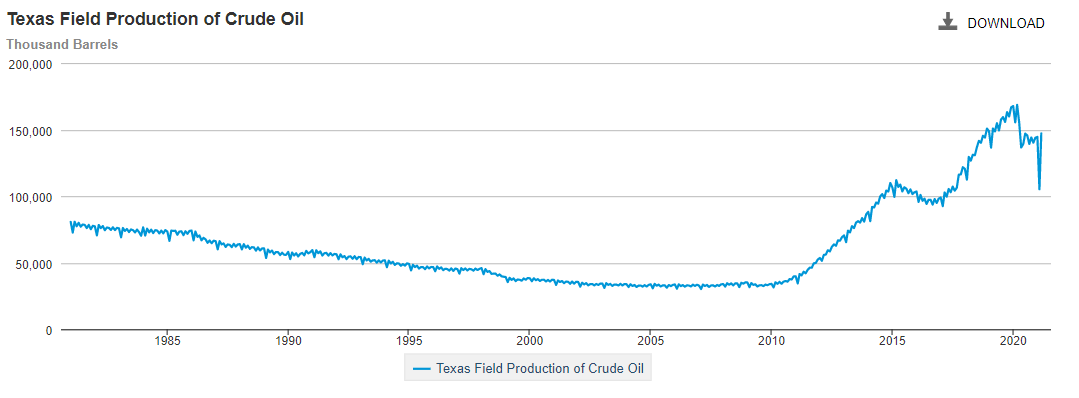

### Water in Coal (Mining dust control)

Data on the location of coal mines, the type of mine (underground vs. surface), and the coal production (tons) is provided in EIA E-7 data for 2015 (https://www.eia.gov/coal/data.php)
The LLNL/NETL assumption is applied that surface mines withdraw 7 gallons of water per ton of coal and underground mines withdraw 29 gallons per ton.
Plants are aggregated by interconnect.
To determine water source/type for mining, the LLNL assumption that the withdrawal follows the distribution of water use for other types of mining in that county.

In [166]:
#USGS 2015 water data
coal_df = pd.read_excel("usco2015v2.0.xlsx", skiprows=1, dtype={'FIPS':str})

#Interconnect by county data file
interconnect = pd.read_excel("County_Interconnect_List.xlsx", dtype={'FIPS':str})
#Dropping unnecessary columns
interconnect = interconnect.drop(["STATE","STATEFIPS","COUNTY","COUNTYFIPS","YEAR","Unnamed: 8"], axis =1)

coal_df = pd.merge(coal_df, interconnect, how="left", on=["FIPS"]) #merging datafiles
coal_df.replace("--", 0, inplace=True) #replacing characters for missing data with value of zero
coal_df = coal_df[["STATE","COUNTY", "Interconnect","MI-WGWFr","MI-WSWFr","MI-WGWSa","MI-WSWSa"]]

In [167]:
#bring in mining data
mining = pd.read_excel("coalpublic2015.xlsx", skiprows=3)
mining = mining.rename(columns={"Mine State": "STATE"})

#cleaning file for state names with regional attributes
mining['STATE'] = np.where(mining['STATE'] == "Kentucky (East)","Kentucky", mining["STATE"])
mining['STATE'] = np.where(mining['STATE'] == "Kentucky (West)","Kentucky", mining["STATE"])
mining['STATE'] = np.where(mining['STATE'] == "Pennsylvania (Bituminous)","Pennsylvania", mining["STATE"])
mining['STATE'] = np.where(mining['STATE'] == "Pennsylvania (Anthracite)","Pennsylvania", mining["STATE"])
mining['STATE'] = np.where(mining['STATE'] == "West Virginia (Northern)","West Virginia", mining["STATE"])
mining['STATE'] = np.where(mining['STATE'] == "West Virginia (Southern)","West Virginia", mining["STATE"])

#dropping refuse recovery rows
mining = mining[(mining[['STATE']] != "Refuse Recovery").all(axis=1)]

codes = pd.read_excel("State_Abbrev_key.xlsx") #bring in state codes
mining = pd.merge(mining, codes, how="left") #merging datafiles
mining = mining[["STATE","Abbrev","Mine County", "Mine Type","Production (short tons)"]]

#fixing the way the county is written from just name to name +County
mining["add"] = "County"
mining['add'] = np.where(mining['Abbrev'] == "LA","Parish", mining["add"]) #LA doesn't have counties, just parishes
mining['add'] = np.where(mining['Abbrev'] == "AK","Borough", mining["add"]) #The one AK county is a borough

#creating a renamed county column for merging with USGS dataset
mining["COUNTY"] = mining["Mine County"] +" " + mining["add"]


In [168]:
mining_clean = mining[["Abbrev","COUNTY","Mine Type","Production (short tons)"]] #grabbing items of interest
mining_clean = mining_clean.rename(columns={"Abbrev": "STATE"}) #rename to prep for merge

#making both county columns uppercase to avoid capitalization differences in merge
mining_clean['COUNTY'] = mining_clean['COUNTY'].str.upper()
coal_df["COUNTY"] = coal_df['COUNTY'].str.upper()

#fixing single case with St. vs St
coal_df['COUNTY'] = np.where(coal_df['COUNTY'] == "ST. CLAIR COUNTY","ST CLAIR COUNTY", coal_df["COUNTY"])

In [169]:
mining_clean = pd.merge(mining_clean, coal_df, how="left") #merging datafiles

In [170]:
#calculating water usage in gallons/ton for each type of mine
mining_clean["MI_Water"]= np.where(mining['Mine Type'] == "Surface", 
                                   mining_clean["Production (short tons)"]*7, 
                                   mining_clean["Production (short tons)"]*29)

In [171]:
#summing the total amount of water going to all mining types from the USGS data
mining_clean["sum"] = mining_clean["MI-WGWFr"] + mining_clean["MI-WSWFr"] + mining_clean["MI-WGWSa"] +mining_clean["MI-WSWSa"] 

#splitting up the coal mining water sources based on proportion of each type sent to all mining
mining_clean['MI_FGW'] = np.where(mining_clean['sum'] != 0, ((mining_clean["MI-WGWFr"]/mining_clean["sum"])*mining_clean["MI_Water"]), 0)
mining_clean['MI_FSW'] = np.where(mining_clean['sum'] != 0, ((mining_clean["MI-WSWFr"]/mining_clean["sum"])*mining_clean["MI_Water"]), 0)
mining_clean['MI_SGW'] = np.where(mining_clean['sum'] != 0, ((mining_clean["MI-WGWSa"]/mining_clean["sum"])*mining_clean["MI_Water"]), 0)
mining_clean['MI_SSW'] = np.where(mining_clean['sum'] != 0, ((mining_clean["MI-WSWSa"]/mining_clean["sum"])*mining_clean["MI_Water"]), 0)

The consumption fraction for all mining is assumed to be consistent for coal mining. No consumption values for 2015 exist in the 2015 dataset. Therefore, 1995 consumptive use for mining is used to calculated the consumption fraction for mining. This fraction is applied to water used in mining for 2015.

Consumption is calculated at a county level using 1995 MI_CF collected earlier. Surface discharge is all water not consumed.

In [172]:
#grabs the mining consumption fraction from the 1995 dataframe
df3 = df2[["State","CountyName","MI_CF"]]
df3 = df3.rename(columns={"County": "COUNTY"})

#fixing the way the county is written from just name to name +County
df3["add"] = "County"
df3['add'] = np.where(df3['State'] == "LA","Parish", df3["add"]) #LA doesn't have counties, just parishes
df3['add'] = np.where(df3['State'] == "AK","Borough", df3["add"]) #The one AK county is a borough

#creating a renamed county column for merging with USGS dataset
df3["COUNTY"] = df3["CountyName"] +" " + df3["add"]
df3['COUNTY'] = df3['COUNTY'].str.upper()

#reducing down to necessary variables
df3 = df3[["COUNTY", "MI_CF"]]

In [173]:
#bringing county consumption fraction data into the mining water use dataframe
mining_clean = pd.merge(mining_clean, df3, how="left")

In [174]:
#calculating consumption and Surface discharge
mining_clean["Coal_CU"] = mining_clean["MI_CF"]*mining_clean["MI_Water"]
mining_clean["Coal_SD"] = (1-mining_clean["MI_CF"])*mining_clean["MI_Water"]

In [175]:
#changing to MGY instead of gallons per year
mining_clean[["MI_FGW","MI_FSW", "MI_SGW","MI_SSW","Coal_CU","Coal_SD"]] = mining_clean[["MI_FGW","MI_FSW", "MI_SGW","MI_SSW","Coal_CU","Coal_SD"]]/1000000
#reducing columns
mining_clean = mining_clean[["Interconnect","MI_FGW","MI_FSW", "MI_SGW","MI_SSW","Coal_CU","Coal_SD"]]

In [176]:
mining_output = mining_clean
mining_output.to_excel("output.xlsx")

In [177]:
#group by interconnect
mining_clean = mining_clean.groupby(["Interconnect"], as_index=False).sum()  
mining_clean = mining_clean.round()

In [178]:
#merge with main dataset
Interconnection_Complete = pd.merge(Interconnection_Complete, mining_clean, how="left", on=["Interconnect"])

In [179]:
#separating out the water to mining from industrial water total to avoid double counting. There is no SSW to coal mining
Interconnection_Complete["INCOM-WGWFr"] = Interconnection_Complete["INCOM-WGWFr"] - Interconnection_Complete["MI_FGW"]
Interconnection_Complete["INCOM-WSWFr"] = Interconnection_Complete["INCOM-WSWFr"] - Interconnection_Complete["MI_FSW"]
Interconnection_Complete["INCOM-WGWSa"] = Interconnection_Complete["INCOM-WGWSa"] - Interconnection_Complete["MI_SGW"]


#subtracting out the consumed portion from the coal mining water from the total consumptive use in industrial/commercial/mining
Interconnection_Complete["INCOM_CU"] = Interconnection_Complete["INCOM_CU"] - Interconnection_Complete["Coal_CU"]

#subtracting out the surface discharge
Interconnection_Complete["INCOM_SD"] = Interconnection_Complete["INCOM_SD"] - Interconnection_Complete["Coal_SD"]

## Bringing in Thermoelectric cooling dataset from other notebook

In [180]:
Thermo_cooling = pd.read_excel(r"C:\Users\mong275\Local Files\Sankey_Notebook_Development\Thermo_output.xlsx")

In [181]:
#merge with main dataset
Interconnection_Complete = pd.merge(Interconnection_Complete, Thermo_cooling, how="left", on=["Interconnect"])

In [182]:
Thermo_cooling.head()

,Unnamed: 0,Interconnect,BIOMASS_Con,COAL_Con,NG_Con,NUCLEAR_Con,OIL_Con,BIOMASS_SD,COAL_SD,NG_SD,...,FR_UM_OIL,OT_OT_BIOMASS,OT_OT_COAL,OT_OT_NG,SA_GW_NG,SA_SW_BIOMASS,SA_SW_COAL,SA_SW_NG,SA_SW_NUCLEAR,SA_SW_OIL
0,0,ERCOT,58.0,154199,41683,18798.0,NaN,22.0,1726317,212648,...,NaN,NaN,NaN,4825.0,NaN,NaN,NaN,136081.0,NaN,NaN
1,1,East,20494.0,1753478,430337,2426191.0,12396.0,206613.0,12385009,972808,...,276.0,708.0,1883.0,1358.0,986.0,20914.0,671208.0,1525538.0,5192986.0,123757.0
2,2,None,NaN,712,266,NaN,829.0,NaN,23612,102,...,219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136269.0
3,3,WECC,2667.0,70427,44966,17808.0,0.0,1054.0,27982,11022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307668.0,726350.0,NaN


<h1> Save to Excel </h1>
Code below prints the main dataframe with all required values for sankey diagram into a single excel xlsx spreadsheet

In [183]:
Interconnection_Complete.to_excel("Interconnection_Complete.xlsx")